# Neutrophil Signature Builder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# import deconvolution methods
import cellanneal
from scipy.optimize import nnls
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler


# statistical tests
import scipy.stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# stats & plot specific from .py files
from src.plot import Plot
from stats import statsTest
from src.helper import flatten, gene_intersection
import src.project_configs as project_configs
from src.deconv import Deconvolution

from tqdm import tqdm

To generate the data, change this to true

In [2]:
train_flag = False

#### GEO Database extractor

In [3]:
logfold = pd.read_csv("../data/differential_expression_results_sorted_MNPs_vs_neutrophs.csv.gz",compression="gzip")
logfold


gene_id   gene_name     baseMean  log2FoldChange     lfcSE  \
0      ENSG00000163464       CXCR1  2714.440255      -10.611624  0.945826   
1      ENSG00000163421       PROK2   724.768096      -10.546696  0.702408   
2      ENSG00000230257        NFE4   131.946940      -10.294377  1.016819   
3      ENSG00000140932       CMTM2   695.458442      -10.278832  0.728488   
4      ENSG00000239839       DEFA3    91.052196      -10.144743  1.040649   
...                ...         ...          ...             ...       ...   
18331  ENSG00000245869  AP004609.1    12.446961        7.120187  1.444368   
18332  ENSG00000205755       CRLF2    22.341429        7.221118  0.937050   
18333  ENSG00000116031       CD207    67.010901        7.735337  1.199967   
18334  ENSG00000158488        CD1E    62.718918        8.720672  0.778834   
18335  ENSG00000102962       CCL22   417.080544        9.178012  0.917534   

            stat        pvalue          padj  
0     -11.219430  3.273740e-29  8.575340e-26  
1     -15.015052  5.851570e-51  1.072940e-46  
2     -10.124098  4.319440e-24  8.800140e-21  
3     -14.109809  3.304710e-45  2.019840e-41  
4      -9.748474  1.872610e-22  2.641250e-19  
...          ...           ...           ...  
18331   4.929620  8.238950e-07  5.766010e-05  
18332   7.706226  1.295930e-14  7.920710e-12  
18333   6.446293  1.146190e-10  3.136800e-08  
18334  11.197085  4.213710e-29  9.657820e-26  
18335  10.002907  1.479880e-23  2.713510e-20  

[18336 rows x 8 columns]

In [4]:
multiply = dict(zip(logfold.gene_name, logfold.log2FoldChange))


In [5]:
multiply

{'CXCR1': -10.61162362,
 'PROK2': -10.54669564,
 'NFE4': -10.29437734,
 'CMTM2': -10.27883218,
 'DEFA3': -10.14474315,
 'FCGR3B': -9.716545924,
 'TGM3': -9.644084021,
 'NECAB2': -9.386147818,
 'AC073172.1': -9.245122996,
 'IL18RAP': -9.196204462,
 'CXCR2': -8.513978786,
 'KIR2DS4': -8.158333322,
 'PGLYRP1': -7.922061392,
 'CSF2RBP1': -7.695975102,
 'PRF1': -7.524324739,
 'LINC00211': -7.380486488,
 'LINC01506': -7.373179869,
 'ROPN1L': -7.213485072,
 'NLRP6': -7.200506872,
 'LINC00664': -7.198387159,
 'GPR27': -7.076298348,
 'GZMA': -6.968121485,
 'LINC02217': -6.950321104,
 'AC007342.3': -6.87098962,
 'MTNR1A': -6.830129531,
 'DRC1': -6.710116498,
 'CYP4F3': -6.697722622,
 'TNFRSF10C': -6.68515234,
 'SLC7A4': -6.667664422,
 'CSNK1A1L': -6.629840368,
 'KLK12': -6.389053519,
 'AC007278.1': -6.352485899,
 'AC020636.1': -6.324202845,
 'FOLR3': -6.19752305,
 'LINC00694': -6.125408855,
 'ALPL': -6.100196244,
 'VNN3': -6.07840598,
 'ADGRG3': -6.054666797,
 'DPP10': -6.024805364,
 'KCNJ15': -

# Neutrophil Deconvolution

In [2]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/Neutrophil-compartment.csv", index_col=0)
atap_bulk = pd.read_csv('../data/atap.pseudobulk_counts.logcpm.csv',index_col=0)
atap_true = pd.read_csv('../data/atap.scg_proportions.csv',index_col=0) 
cleveland_bulk = pd.read_csv('../data/cleveland.pseudobulk_counts.logcpm.csv',index_col=0)
cleveland_true = pd.read_csv('../data/cleveland.scg_proportions.csv',index_col=0)
lmu_bulk = pd.read_csv('../data/lmu.pseudobulk_counts.logcpm.csv',index_col=0)
lmu_true = pd.read_csv('../data/lmu.scg_proportions.csv',index_col=0)

In [3]:
atap_true_general =pd.DataFrame()          
atap_true_general['Myeloid'] = atap_true['CD209+ moDC'] + atap_true['CD83+ CLEC9A+ DC'] + atap_true['CD83- CLEC9A+ DC']+atap_true['CLEC10A+ DC']+atap_true['IL7R+ Activated DC']+atap_true['LTB+ DC']+atap_true['Mast Cell']+atap_true['Monocyte Inflammatory']+atap_true['Proliferating myeloid']+atap_true['Resident Macrophage']
atap_true_general['T Cell'] = atap_true['CD4 SELL naive'] + atap_true['CD4 TRM'] + atap_true['CD4 Tfh']+atap_true['CD4 Th17']+atap_true['CD4 Tfr'] + atap_true['CD4 Th1']+atap_true['CD4 Tph']+atap_true['CD4 Treg']+atap_true['CD8 Effector']+atap_true['CD8 IEL']+atap_true['CD8 SELL Naive']+atap_true['ILC3']+atap_true['MAIT']+atap_true['NK']+atap_true['Proliferating T cells']+atap_true['gd T cell 1']+atap_true['gd T cell 2']
atap_true_general['B Cell'] = atap_true['GC-like B cell'] + atap_true['Memory B cell'] + atap_true['Naive B cell']+atap_true['Plasma Cell']+atap_true['Plasmablast']
atap_true_general['Stroma'] = atap_true['Arterial Pericyte'] + atap_true['Blood Endothelial Cell'] + atap_true['Fibroblast']+atap_true['Glial Cell']+atap_true['Inflammatory Fibroblast']+atap_true['Lymphatic Endothelial Cell']+atap_true['Myofibroblast']+atap_true['Pericyte']+atap_true['Post-capillary venules']+atap_true['Proliferating Stromal Cell']+atap_true['Smooth Muscle Cell']
atap_true_general['Epithelium'] = atap_true['Enterocyte'] + atap_true['Enteroendocrine Cell'] + atap_true['Epithelial M Cell']+atap_true['Epithelial Progenitor Cell']+atap_true['Epithelial Stem Cell']+atap_true['Goblet Cell']+atap_true['Tuft Cell']

In [4]:
deconvolution_object = Deconvolution()
plot_object = Plot()

In [5]:
# plot parameters all coming from project.configurations
plt.style.use(project_configs.style)
plt.rcParams['font.family'] = project_configs.font_family
plt.rcParams['font.serif'] = project_configs.font_serif
plt.rcParams['font.monospace'] = project_configs.font_monospace
plt.rcParams['font.size'] = project_configs.font_size
plt.rcParams['axes.labelsize'] = project_configs.axes_label_size
plt.rcParams['axes.labelweight'] = project_configs.axes_label_weight
plt.rcParams['axes.titlesize'] = project_configs.axes_title_size
plt.rcParams['xtick.labelsize'] = project_configs.xtick_label_size
plt.rcParams['ytick.labelsize'] = project_configs.ytick_label_size
plt.rcParams['legend.fontsize'] = project_configs.legend_font_size 
plt.rcParams['figure.titlesize'] = project_configs.figure_title_size
plt.rcParams['image.cmap'] = project_configs.image_cmap 
plt.rcParams['image.interpolation'] = project_configs.image_interpolation 
plt.rcParams['figure.figsize'] = project_configs.figure_size
plt.rcParams['axes.grid']=project_configs.axes_grid
plt.rcParams['lines.linewidth'] = project_configs.lines_line_width
plt.rcParams['lines.markersize'] = project_configs.lines_marker_size
cells_p = project_configs.cells_p

# Less Markers

In [10]:
logfold = pd.read_excel("../data/neu-mnp.xlsx",index_col=0)
logfold

gene_name     baseMean  log2FoldChange     lfcSE       stat  \
gene_id                                                                         
ENSG00000102962       CCL22   417.080544        9.178012  0.917534  10.002907   
ENSG00000158488        CD1E    62.718918        8.720672  0.778834  11.197085   
ENSG00000116031       CD207    67.010901        7.735337  1.199967   6.446293   
ENSG00000205755       CRLF2    22.341429        7.221118  0.937050   7.706226   
ENSG00000245869  AP004609.1    12.446961        7.120187  1.444368   4.929620   
...                     ...          ...             ...       ...        ...   
ENSG00000239839       DEFA3    91.052196      -10.144743  1.040649  -9.748474   
ENSG00000140932       CMTM2   695.458442      -10.278832  0.728488 -14.109809   
ENSG00000230257        NFE4   131.946940      -10.294377  1.016819 -10.124098   
ENSG00000163421       PROK2   724.768096      -10.546696  0.702408 -15.015052   
ENSG00000163464       CXCR1  2714.440255      -10.611624  0.945826 -11.219430   

                       pvalue          padj  
gene_id                                      
ENSG00000102962  1.479880e-23  2.713509e-20  
ENSG00000158488  4.213708e-29  9.657818e-26  
ENSG00000116031  1.146191e-10  3.136800e-08  
ENSG00000205755  1.295928e-14  7.920711e-12  
ENSG00000245869  8.238951e-07  5.766008e-05  
...                       ...           ...  
ENSG00000239839  1.872613e-22  2.641248e-19  
ENSG00000140932  3.304713e-45  2.019841e-41  
ENSG00000230257  4.319441e-24  8.800142e-21  
ENSG00000163421  5.851575e-51  1.072945e-46  
ENSG00000163464  3.273743e-29  8.575335e-26  

[2069 rows x 7 columns]

In [11]:
multiply2 = dict(zip(logfold.gene_name, logfold.log2FoldChange))

# reduce gene markers

In [12]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(multiply2)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

82


In [13]:
df

B Cell  Epithelium   Myeloid    Stroma    T Cell  Neutrophil
IGHV3-13   4.980656    1.333944  1.864680  1.532558  1.954512    1.864680
CEACAM7    4.380691    9.786583  3.619825  2.426693  3.630942    3.619825
HNF4A      3.485610    8.545540  2.476539  1.870433  2.601221    2.476539
IGLV10-54  6.287763    1.377721  2.887041  2.401113  3.306973    2.887041
RAB25      4.972021    9.833682  3.448122  2.608023  4.056638    3.448122
...             ...         ...       ...       ...       ...         ...
TRGC1      2.219735    1.275100  4.801744  0.742623  8.243333    4.801744
IFI30      8.746951    4.623365  9.757329  3.657667  4.645844   12.470294
VIL1       4.750310    9.462102  3.779563  2.664320  4.173139    3.779563
BMP5       2.511312    0.784588  2.129530  7.798015  1.550607    2.129530
SDS        3.441781    1.015685  8.974986  1.453542  2.404653   11.346986

[503 rows x 6 columns]

In [14]:
temp = df.iloc[:,-1]
temp=temp[temp!=0]
temp = temp.sort_values()
temp

KLK12       -5.569969
ALPL        -4.838718
ITLN2       -4.682456
LTF         -3.564156
KLRD1       -2.664482
              ...    
HLA-DPB1    15.447853
HLA-DRA     15.657335
CCL22       16.329279
FCER1A      16.333125
CD1E        16.492995
Name: Neutrophil, Length: 502, dtype: float64

In [15]:
multiply = dict(zip(temp.index, temp.values))

# takes top N genes

In [16]:
cells_p = {'B Cell': '#558ce0',
            'T Cell': '#28a35c',
            'Myeloid': '#58d3bb',
            'Stroma': '#eaabcc',
            'Epithelium': '#F6783E',
}

In [17]:
log = {A:N for (A,N) in [x for x in multiply.items()][:80]}

In [18]:
log

{'KLK12': -5.569968698532718,
 'ALPL': -4.838717942361145,
 'ITLN2': -4.682455756981469,
 'LTF': -3.564156144119388,
 'KLRD1': -2.664481764723114,
 'GZMA': -2.071523408258189,
 'PCSK1N': -1.8992199174638573,
 'DDC': -1.6193924939830078,
 'CHGA': -1.02310895244942,
 'HEPACAM2': -0.961300749459808,
 'PRSS8': -0.045467908299362314,
 'TRDC': -0.031093352447803646,
 'SOHLH2': 0.0221602565294122,
 'SLPI': 0.03161245426447845,
 'IGKV5-2': 0.0656526905370294,
 'PMCH': 0.1544966532416736,
 'MEOX2': 0.175543317403987,
 'GJA5': 0.1801452705883998,
 'IGKV2-28': 0.2567912643322231,
 'FNDC1': 0.3047688219410484,
 'IL22RA1': 0.3485663334444661,
 'FEV': 0.4089473814332727,
 'IGKV1D-43': 0.4324305026443017,
 'CDH19': 0.4396922030924369,
 'MYOCD': 0.4495288977422345,
 'EFS': 0.5338010535951228,
 'IGLV5-37': 0.5457191768676704,
 'IL13RA2': 0.5950079852470382,
 'DHRS7C': 0.623045369727788,
 'IGLV9-49': 0.6922499783494223,
 'DKK1': 0.6948288099643493,
 'FAM13C': 0.7259209328818284,
 'PAEP': 0.7539114363205

In [19]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
df = df.drop("logfold",axis=1)
df[df < 0] = 0
signature = df


In [20]:
signature.T.KLK12

B Cell        2.017800
Epithelium    5.258521
Myeloid       0.819085
Stroma        0.377455
T Cell        0.644127
Neutrophil    0.000000
Name: KLK12, dtype: float64

In [21]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top80.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top80.csv",index_col=0)

(0.0, 1.0)

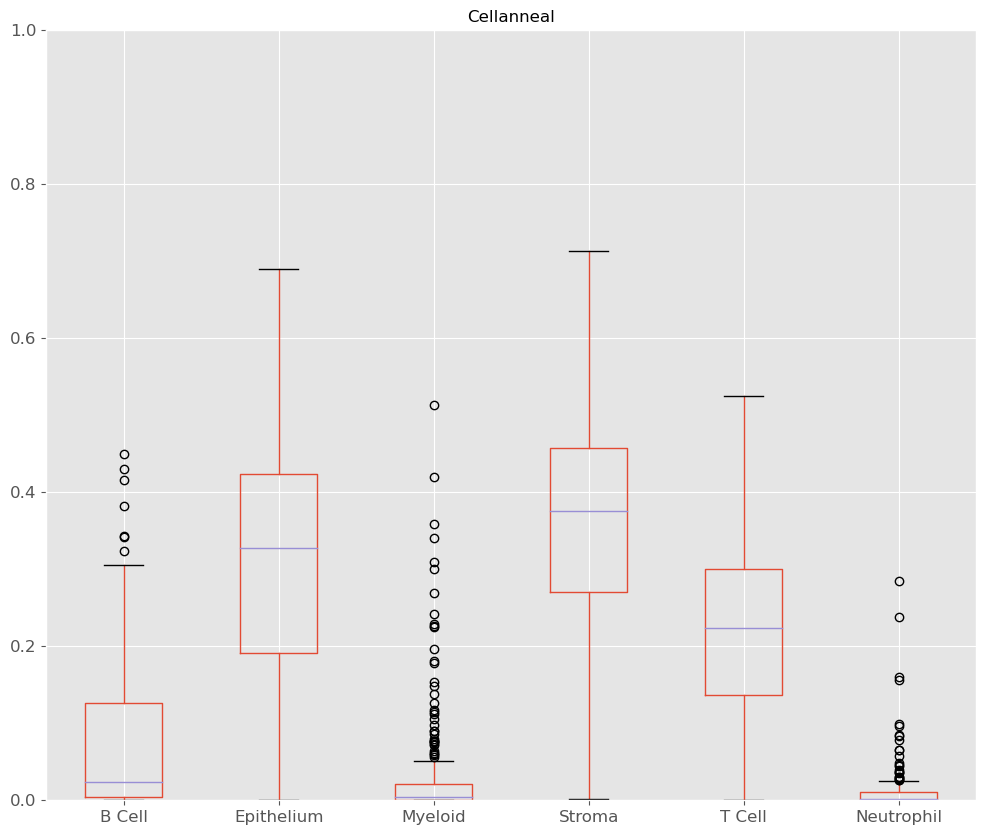

In [22]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [23]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.373\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.921\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.622\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.857\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.893\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

In [24]:
cellanneal_atap.describe()

B Cell  Epithelium     Myeloid      Stroma      T Cell  Neutrophil  \
count  223.000000  223.000000  223.000000  223.000000  223.000000  223.000000   
mean     0.076985    0.306633    0.033311    0.351877    0.218602    0.012592   
std      0.098380    0.168276    0.075391    0.135794    0.112255    0.032305   
min      0.000008    0.000149    0.000018    0.001836    0.000088    0.000004   
25%      0.004283    0.191227    0.000702    0.270213    0.136908    0.000599   
50%      0.024102    0.327026    0.003650    0.375737    0.223553    0.002203   
75%      0.126803    0.424149    0.021397    0.457962    0.300690    0.010802   
max      0.449896    0.689563    0.513452    0.712940    0.524686    0.284916   

       rho_Spearman  rho_Pearson  
count    223.000000   223.000000  
mean       0.809673     0.699909  
std        0.098936     0.132738  
min        0.500259     0.328906  
25%        0.728162     0.613062  
50%        0.837517     0.719702  
75%        0.895231     0.809692  
max        0.943434     0.888497

# 60 genes

In [25]:
log = {A:N for (A,N) in [x for x in multiply.items()][:60]}

In [26]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

60


In [27]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top60.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top60.csv",index_col=0)

In [28]:
cellanneal_atap.describe()

B Cell  Epithelium     Myeloid      Stroma      T Cell  Neutrophil  \
count  223.000000  223.000000  223.000000  223.000000  223.000000  223.000000   
mean     0.131613    0.310079    0.038477    0.284258    0.224514    0.011059   
std      0.109214    0.185954    0.078430    0.150940    0.145458    0.021083   
min      0.000013    0.000032    0.000039    0.000478    0.000029    0.000009   
25%      0.038632    0.179194    0.002522    0.169207    0.110334    0.000627   
50%      0.106833    0.320575    0.008338    0.312982    0.227869    0.003327   
75%      0.197796    0.439182    0.030739    0.390641    0.320770    0.011753   
max      0.448858    0.807390    0.486175    0.628581    0.607587    0.182242   

       rho_Spearman  rho_Pearson  
count    223.000000   223.000000  
mean       0.823676     0.702723  
std        0.083810     0.130171  
min        0.544962     0.309430  
25%        0.779625     0.631580  
50%        0.849142     0.734272  
75%        0.886197     0.799309  
max        0.936912     0.900820

In [29]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [30]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.433\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.926\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.481\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.843\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.902\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

# 40 genes

In [31]:
log = {A:N for (A,N) in [x for x in multiply.items()][:40]}

In [32]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

40


In [33]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top40.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top40.csv",index_col=0)

In [34]:
cellanneal_atap.describe()

B Cell  Epithelium     Myeloid      Stroma      T Cell  Neutrophil  \
count  223.000000  223.000000  223.000000  223.000000  223.000000  223.000000   
mean     0.128985    0.286237    0.039462    0.326954    0.203379    0.014983   
std      0.106754    0.175926    0.062537    0.122267    0.115898    0.047504   
min      0.000114    0.000018    0.000042    0.010347    0.000056    0.000004   
25%      0.038030    0.156666    0.002731    0.254092    0.119715    0.000573   
50%      0.098194    0.294272    0.010726    0.345430    0.199177    0.001587   
75%      0.208872    0.416867    0.045124    0.406414    0.273231    0.005777   
max      0.436050    0.715661    0.297098    0.697792    0.497952    0.341138   

       rho_Spearman  rho_Pearson  
count    223.000000   223.000000  
mean       0.842135     0.705870  
std        0.078724     0.089474  
min        0.613165     0.452175  
25%        0.780956     0.640114  
50%        0.863161     0.729452  
75%        0.904959     0.770500  
max        0.950508     0.844436

In [35]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [36]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.472\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.925\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.607\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.886\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.843\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

# 20 genes

In [37]:
log = {A:N for (A,N) in [x for x in multiply.items()][:20]}

In [38]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

20


In [39]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top20.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top20.csv",index_col=0)
    pass

In [40]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [41]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.455\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.916\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.678\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.851\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.843\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

# 15 genes

In [42]:
log = {A:N for (A,N) in [x for x in multiply.items()][:15]}

In [43]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

15


In [44]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top15.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top15.csv",index_col=0)
    pass

In [45]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [46]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.449\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.902\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.684\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.844\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.849\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

# 10 genes

In [47]:
log = {A:N for (A,N) in [x for x in multiply.items()][:10]}

In [48]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

10


In [49]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top10.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top10.csv",index_col=0)
    pass

In [50]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [51]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.468\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.896\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.606\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.782\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.868\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

# added final genes

In [52]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv",index_col=0)

In [53]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(20).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [54]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil2.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil2.csv",index_col=0)
    pass

In [55]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [56]:
l = ['S100A4', 'SRGN', 'IFITM2', 'S100A8', 'S100A9', 'HLA-DRA', 'HLA-DPB1']
for i in l:
    ref = ref.drop(i)


In [57]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil3.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil3.csv",index_col=0)
    pass

In [58]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [59]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv",index_col=0)

In [60]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(40).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [61]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil4.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil4.csv",index_col=0)
    pass

In [62]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

(0.0, 1.0)

In [63]:
plot_object.plot_cell(cellanneal_atap.T,atap_true_general.T,pallete=cells_p)

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.481\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.948\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.281\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.824\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.836\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

In [64]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv",index_col=0)

# final 

## 40

In [65]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv", index_col=0)
df['logfold']= df.index.map(multiply2)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

170


In [66]:
temp = df.iloc[:,-1]
temp=temp[temp!=0]
temp = temp.sort_values()
temp

CXCR1      -10.611624
PROK2      -10.546696
NFE4       -10.294377
CMTM2      -10.278832
DEFA3      -10.144743
              ...    
HLA-DPB1    15.447853
HLA-DRA     15.657335
CCL22       16.329279
FCER1A      16.333125
CD1E        16.492995
Name: Neutrophil, Length: 590, dtype: float64

In [67]:
multiply = dict(zip(temp.index, temp.values))

In [68]:
log = {A:N for (A,N) in [x for x in multiply.items()][:40]}

In [69]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

40


In [70]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_top40.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_top40.csv",index_col=0)
    pass

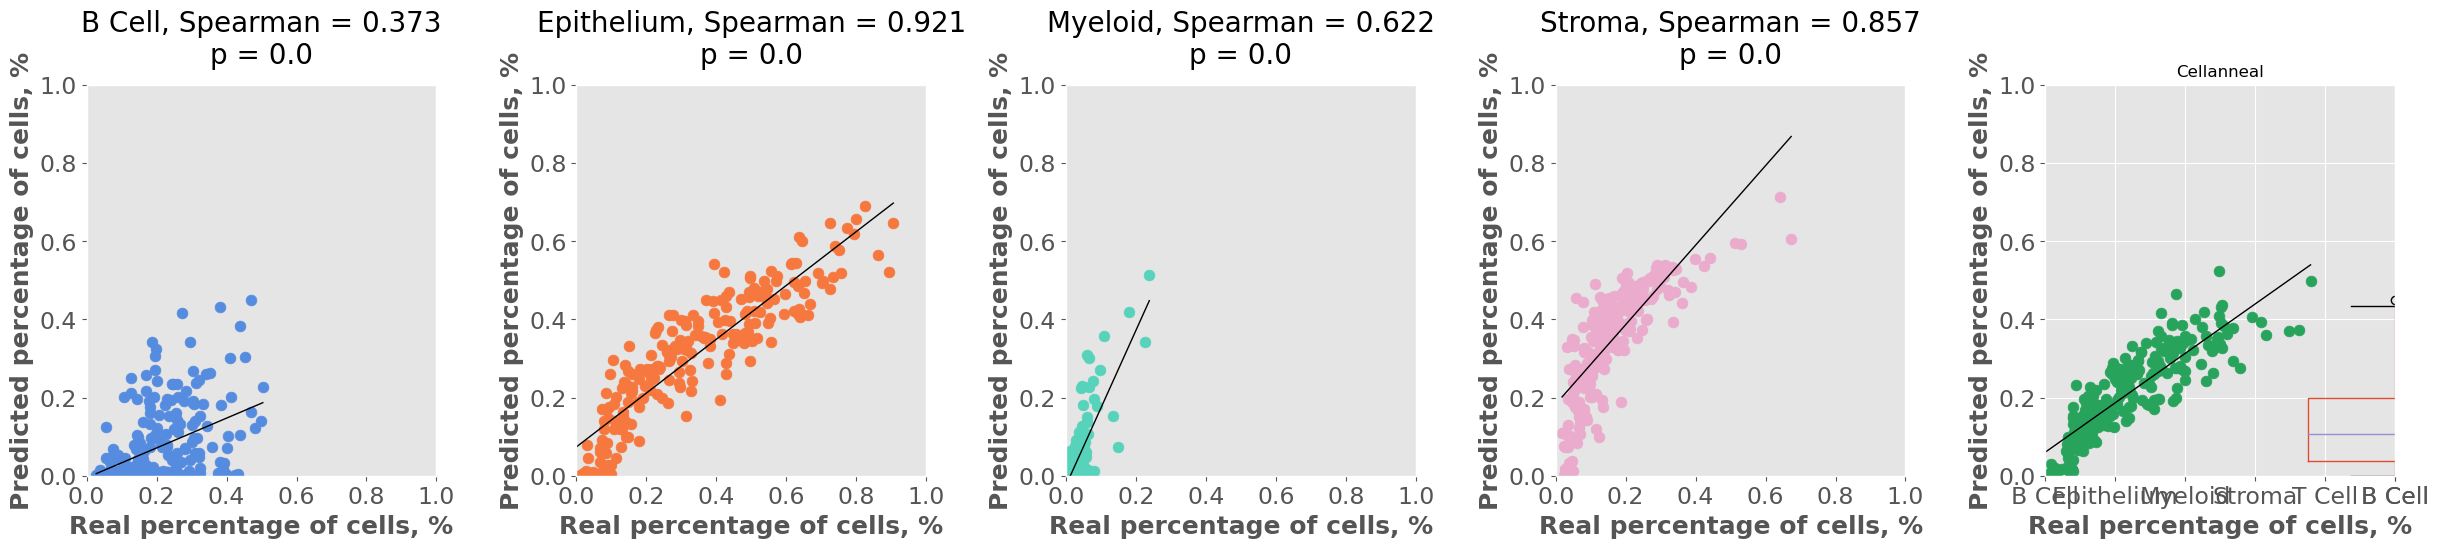

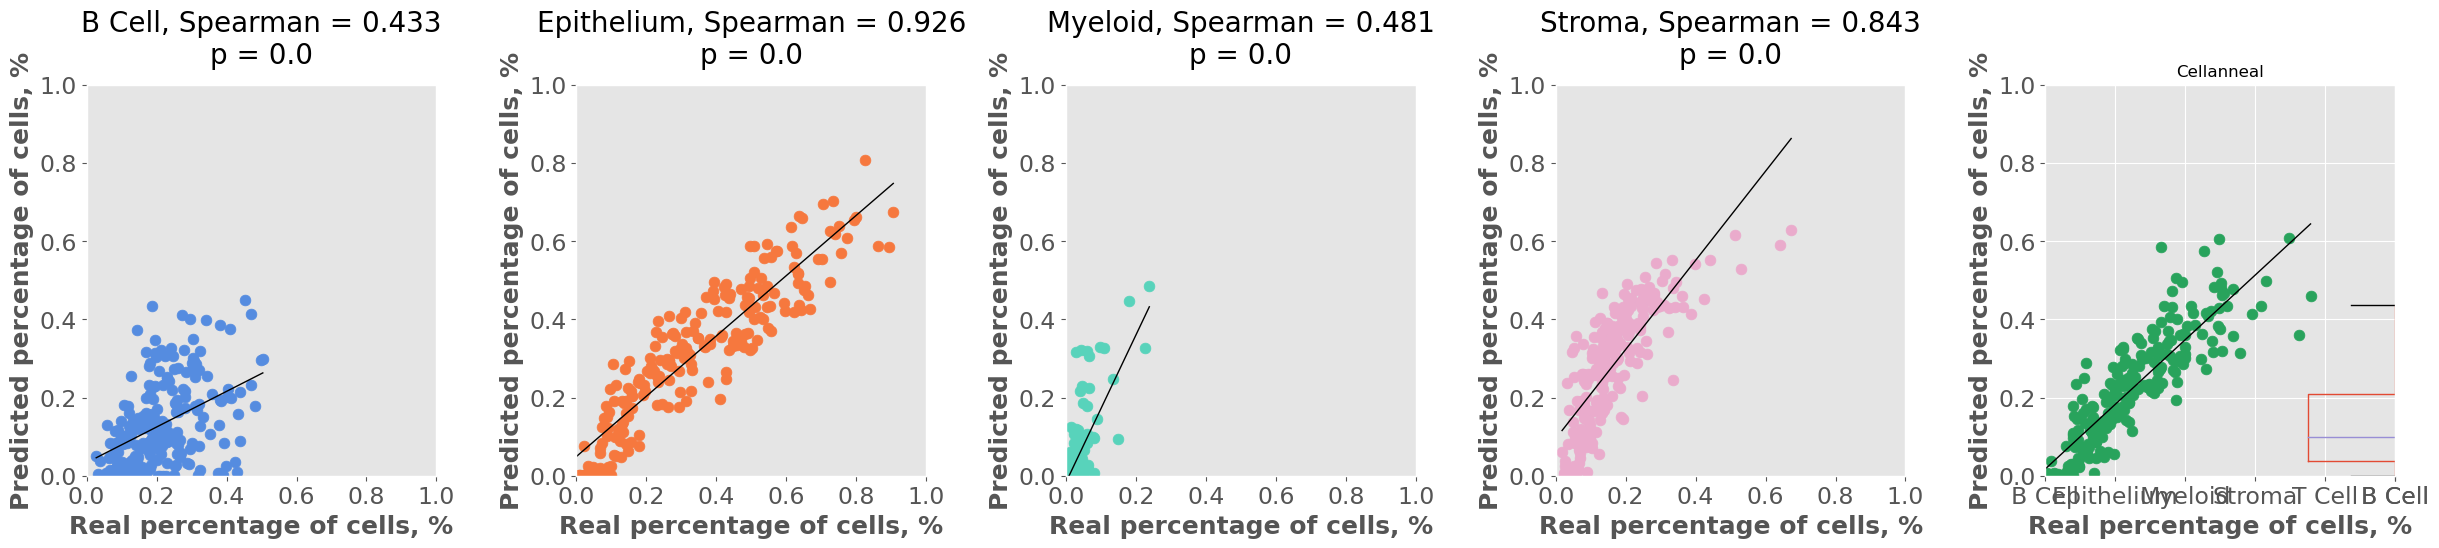

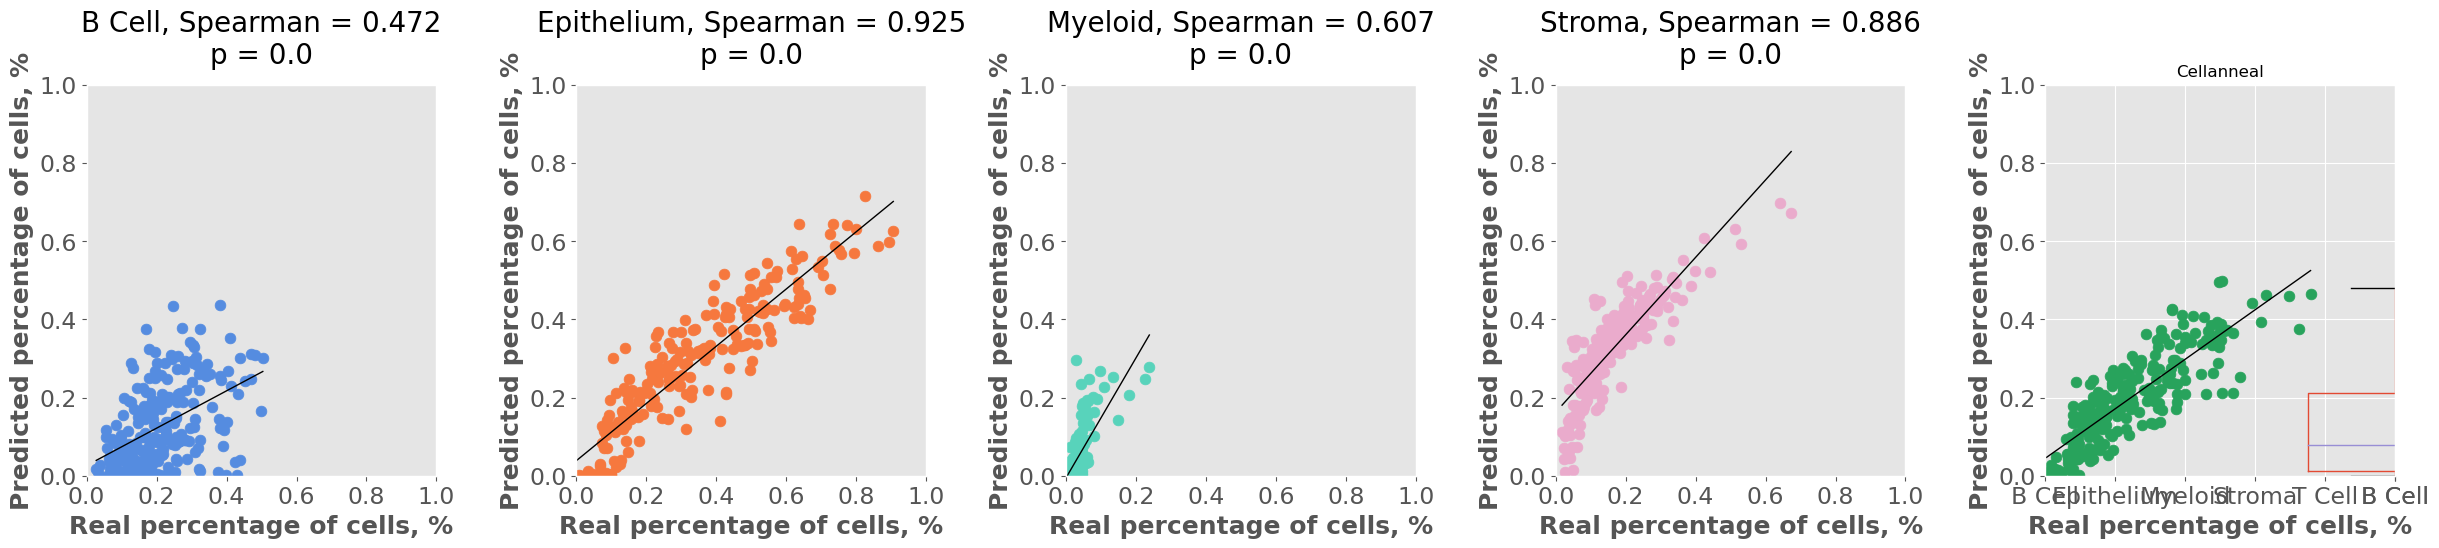

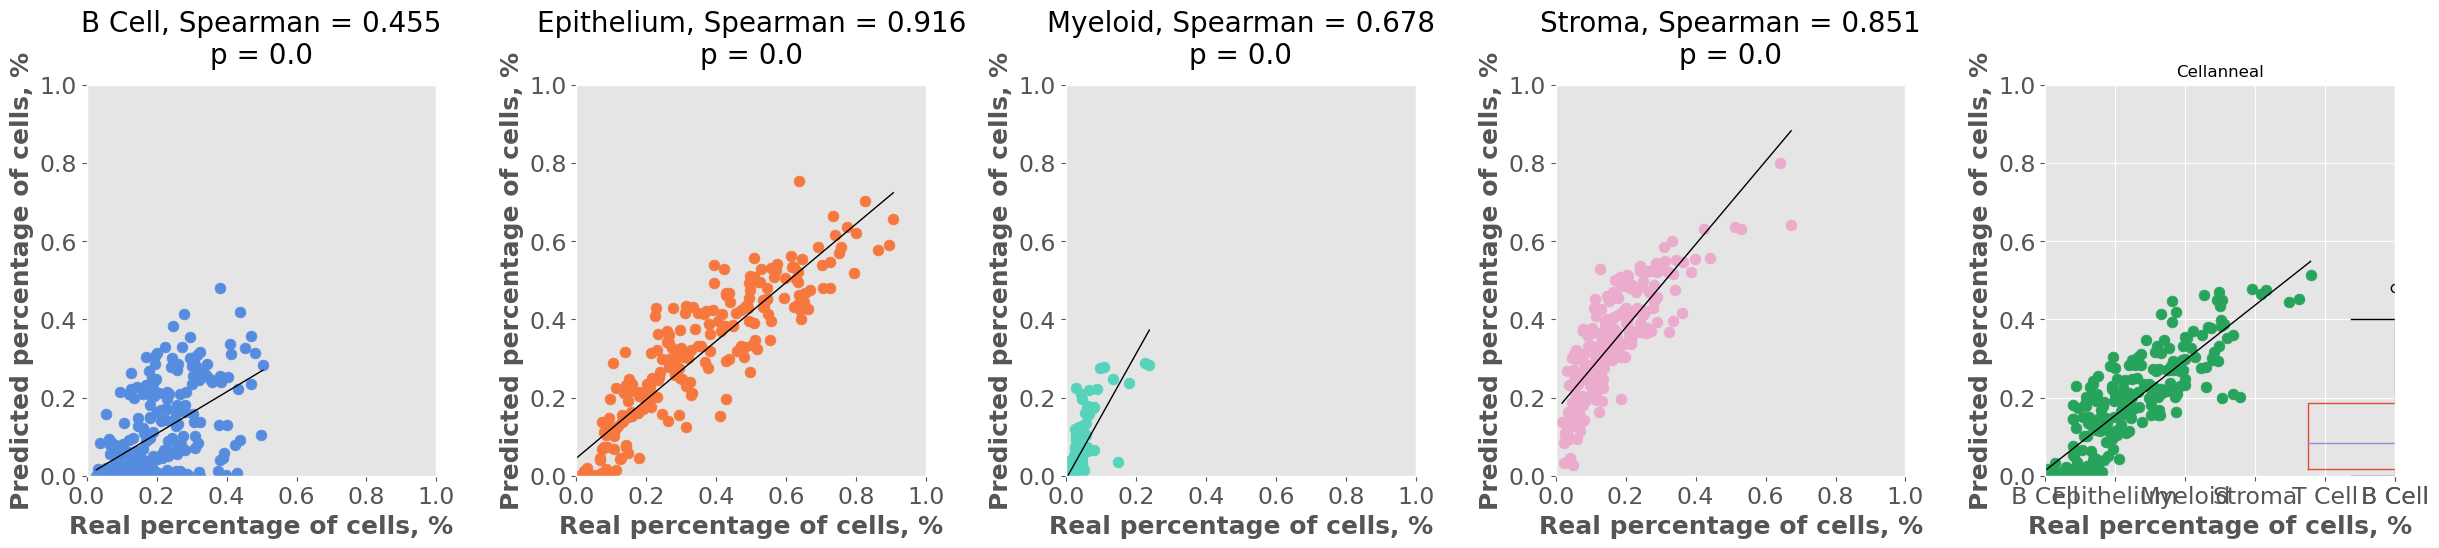

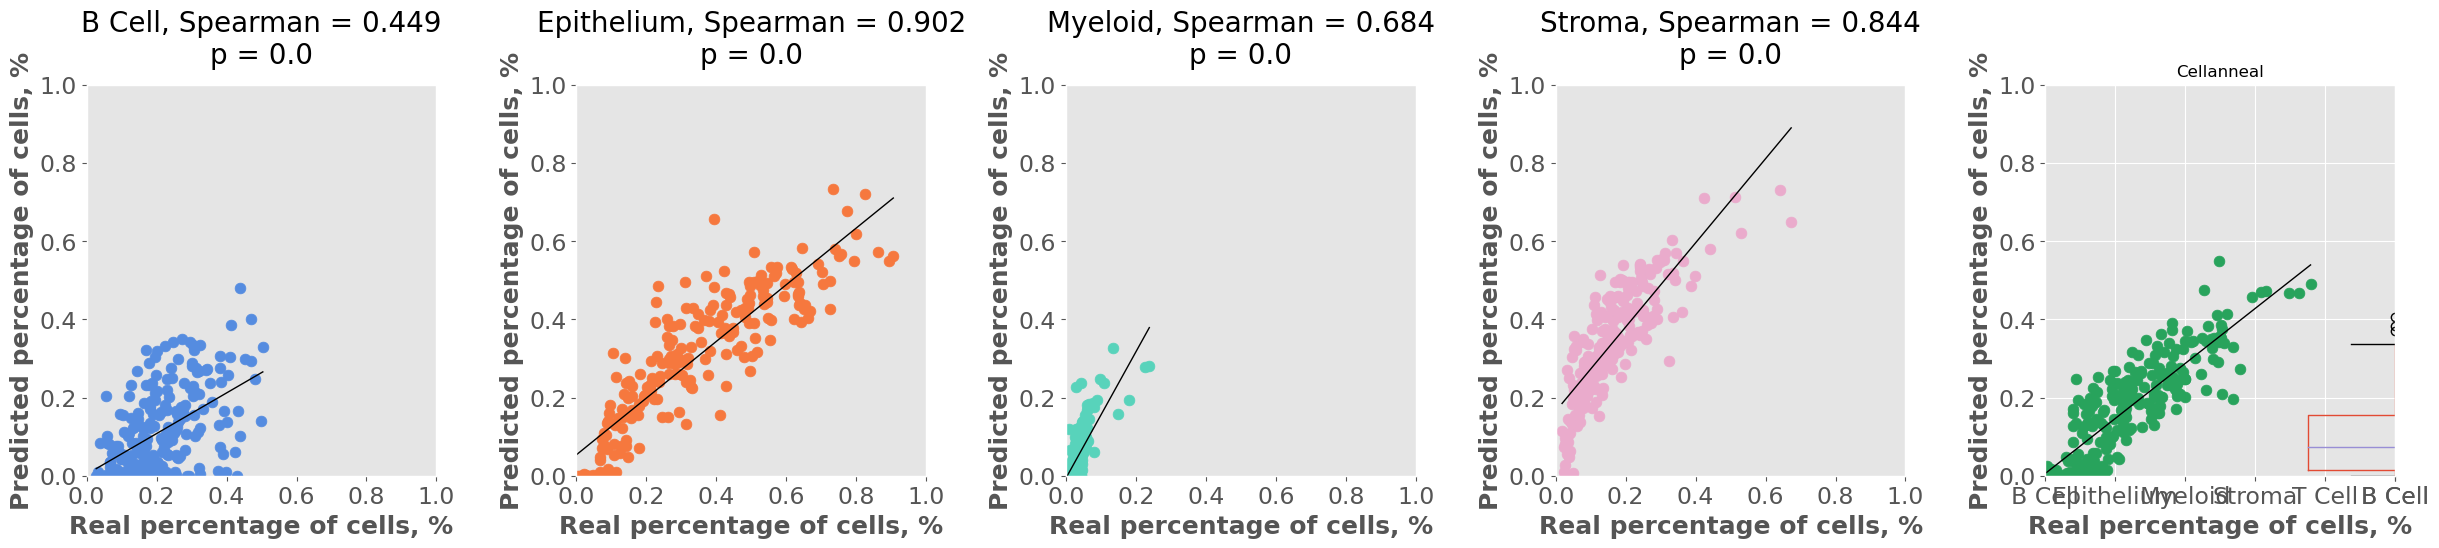

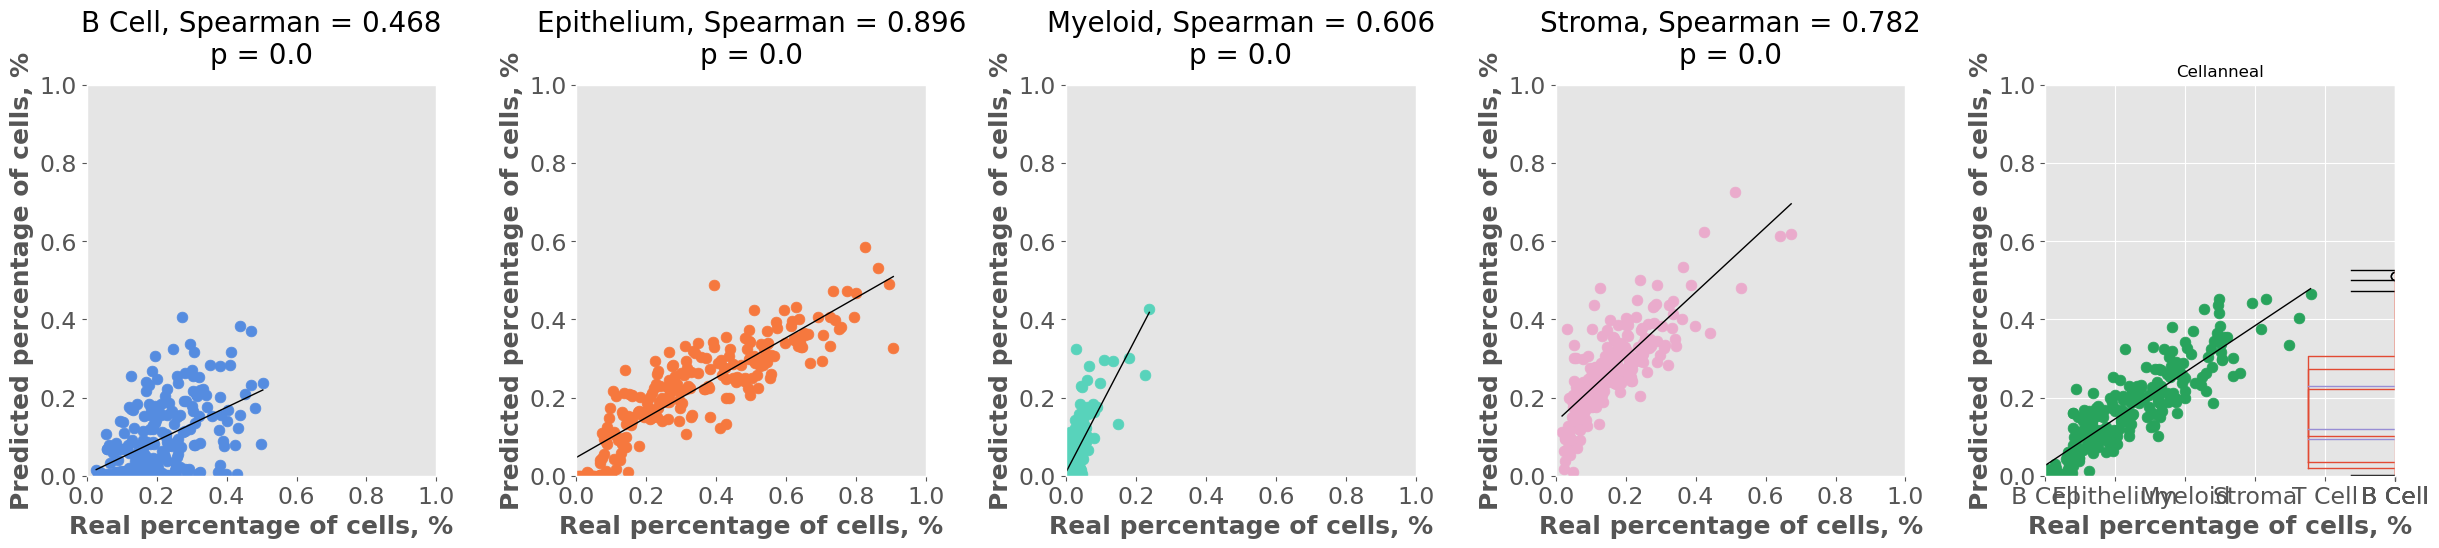

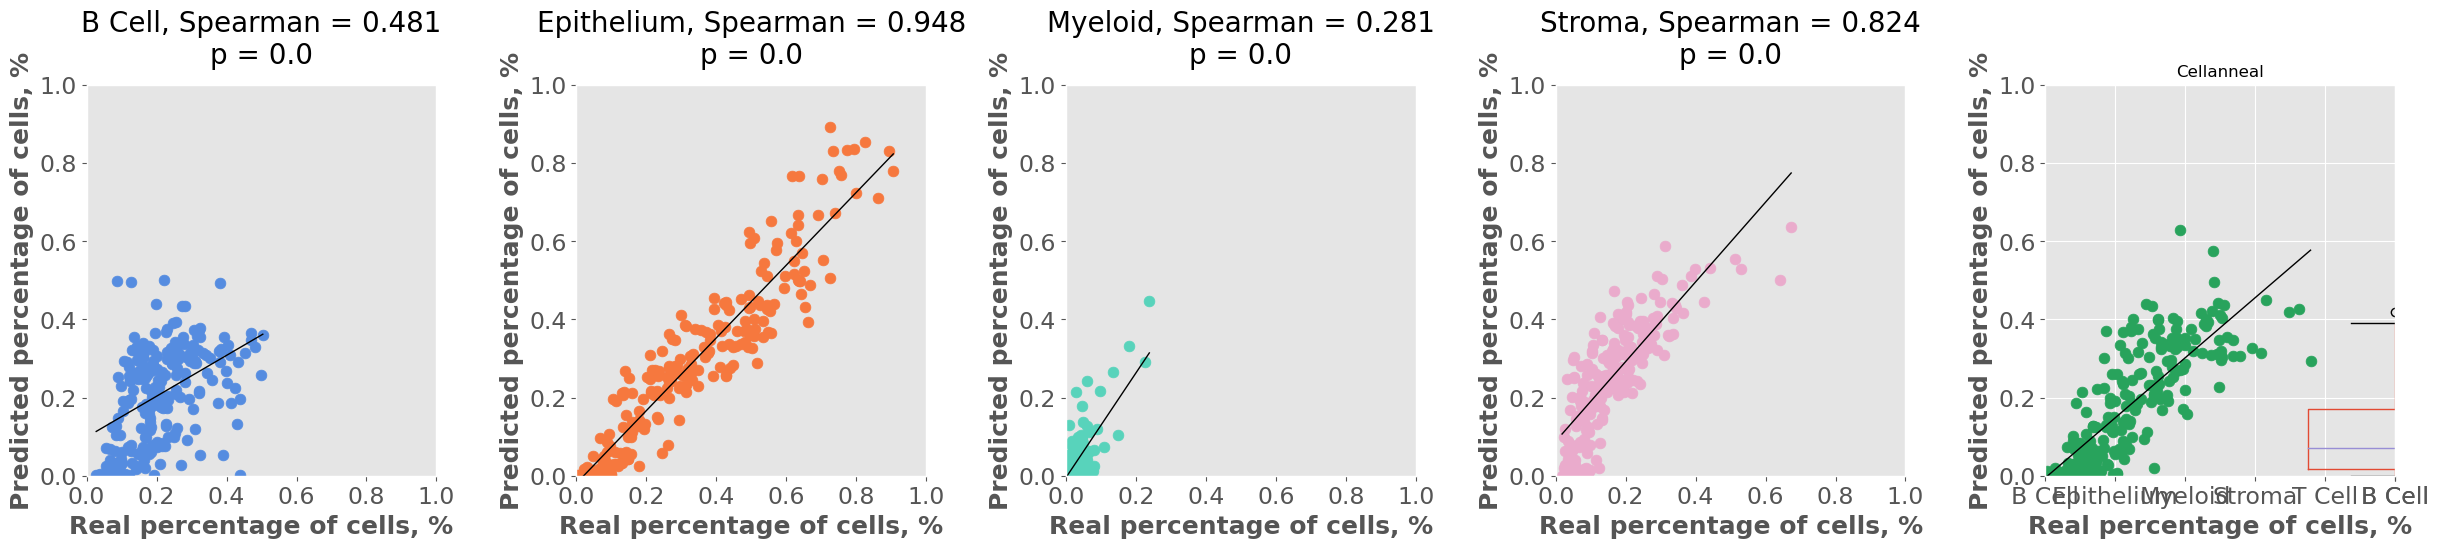

In [71]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

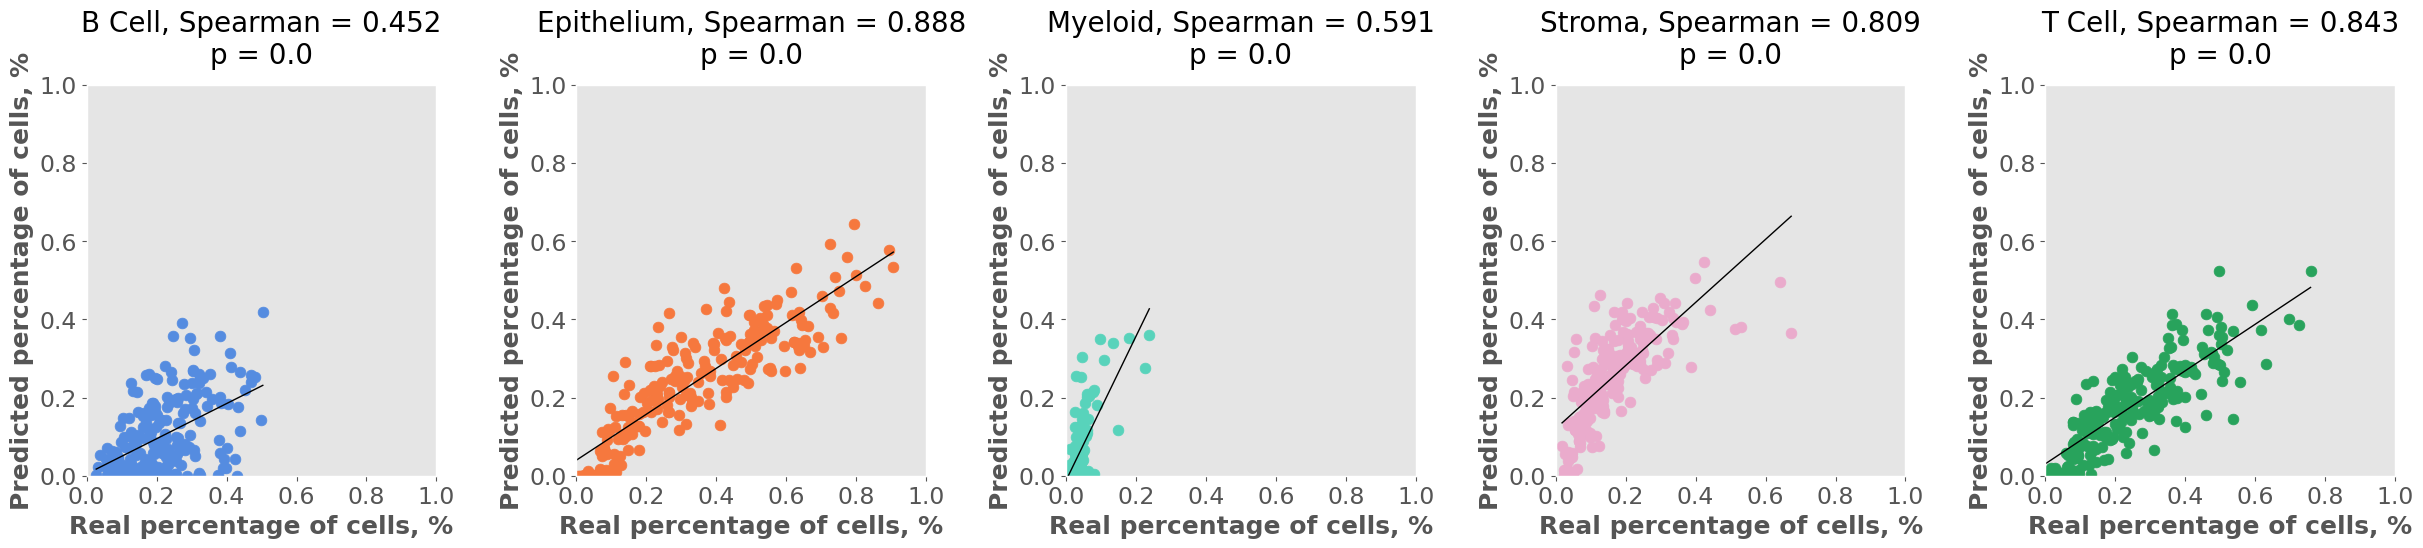

In [72]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()

## 20

In [73]:
log = {A:N for (A,N) in [x for x in multiply.items()][:20]}

In [74]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

20


In [75]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_top20.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_top20.csv",index_col=0)
    pass

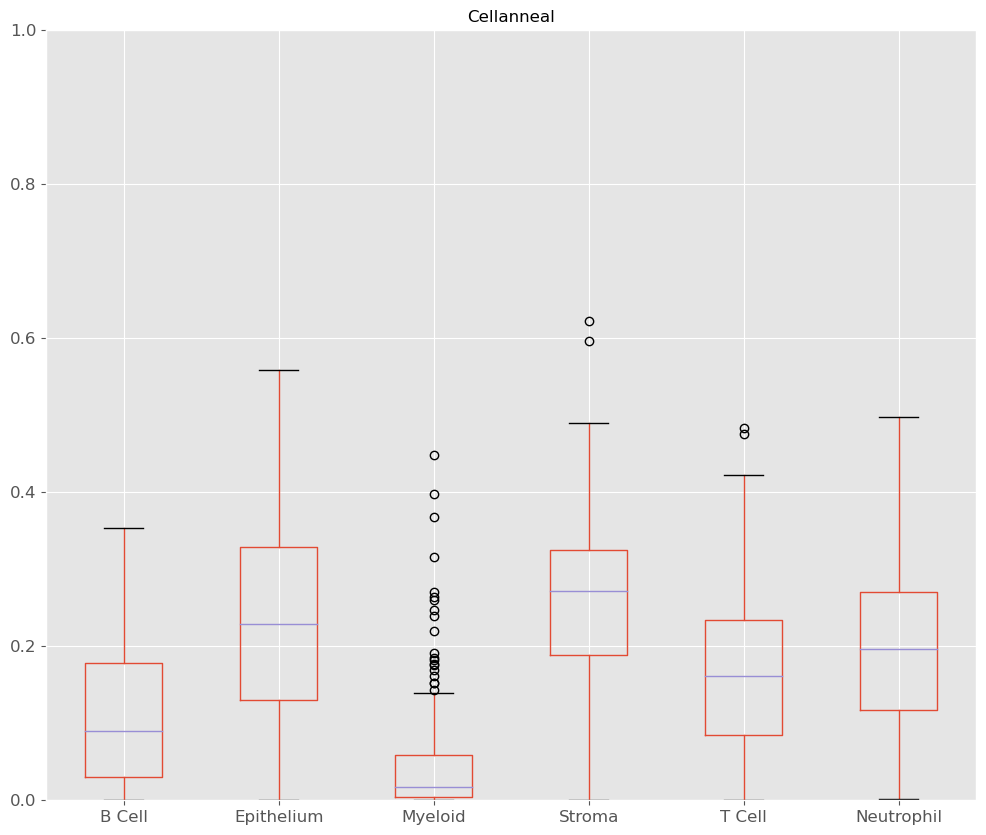

In [76]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

In [77]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv", index_col=0)


In [78]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil.csv",index_col=0)
    pass

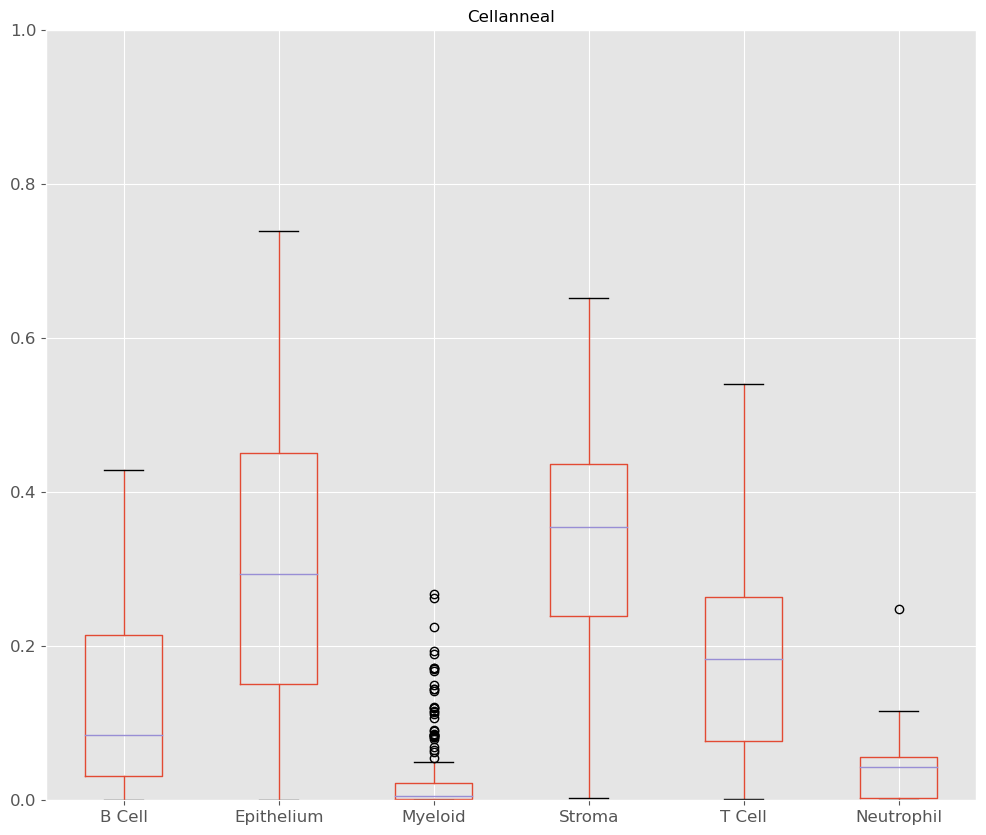

In [79]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

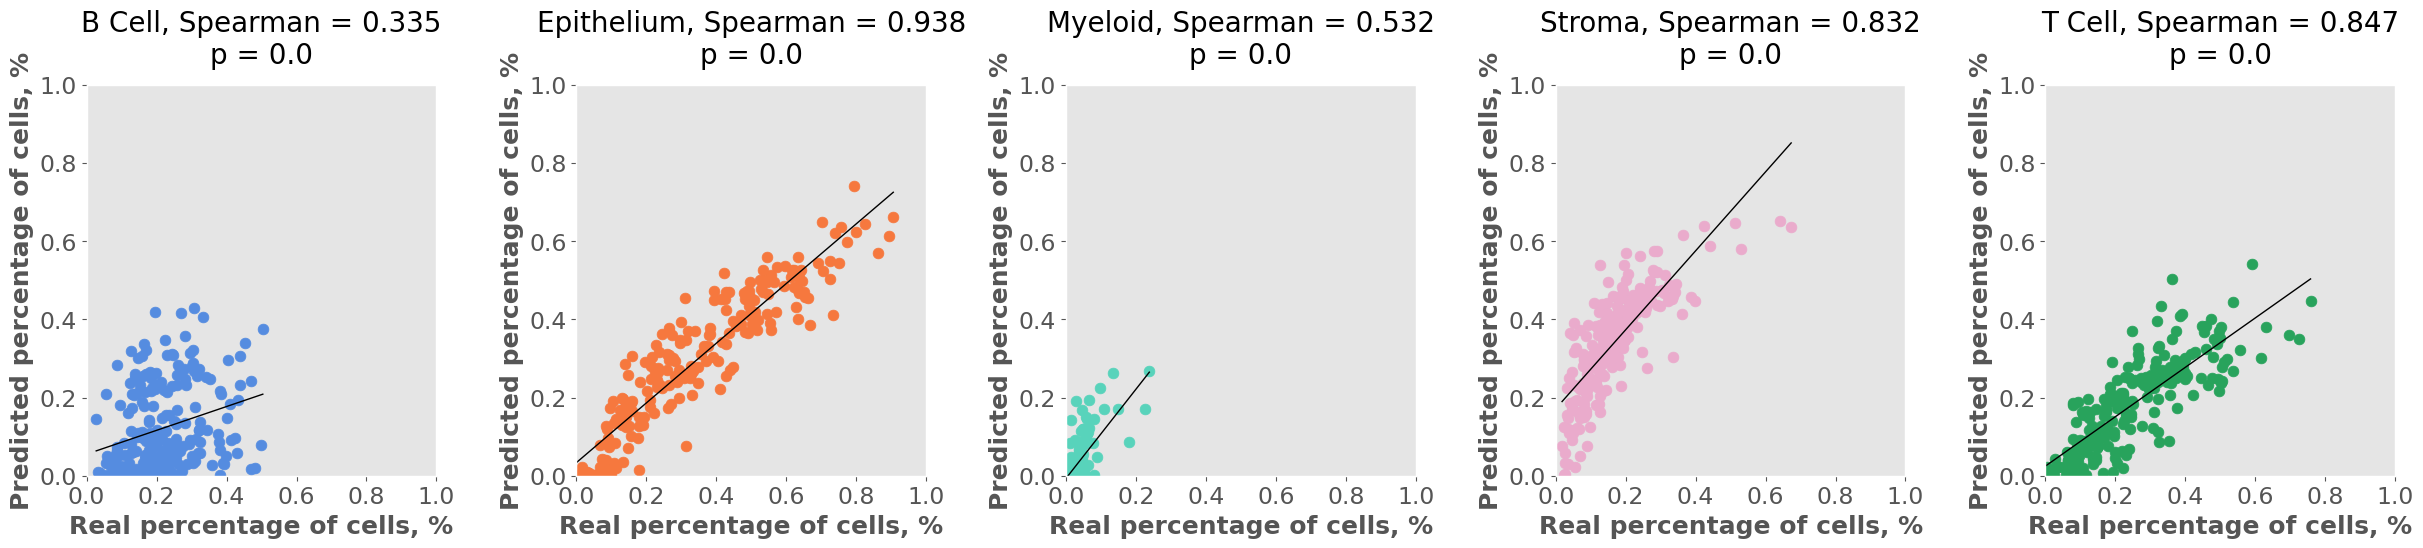

In [80]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()

In [81]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(50).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [82]:
ref

B Cell  Epithelium    Myeloid    Stroma     T Cell  Neutrophil
index                                                                        
ABCA8        4.078487    1.601451   2.721017  9.498291   3.094153    0.000000
AC007278.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.078481
AC007342.3   0.000000    0.000000   0.000000  0.000000   0.000000   18.596984
AC011472.2   0.000000    0.000000   0.000000  0.000000   0.000000   16.966225
AC012645.1   0.000000    0.000000   0.000000  0.000000   0.000000   17.160102
...               ...         ...        ...       ...        ...         ...
UGT2B17      6.093878   10.359428   4.518254  3.251111   4.558168    0.000000
VNN3         0.000000    0.000000   0.000000  0.000000   0.000000   17.804401
VPREB3      11.574543    2.818467   4.884204  2.316491   4.995429    0.000000
VSIG2        5.084660   10.173351   3.255996  3.592262   4.025002    0.000000
ZNF331      11.121237    4.951071  10.011778  6.260785  11.157730    7.712262

[237 rows x 6 columns]

In [83]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_50.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_50.csv",index_col=0)
    pass

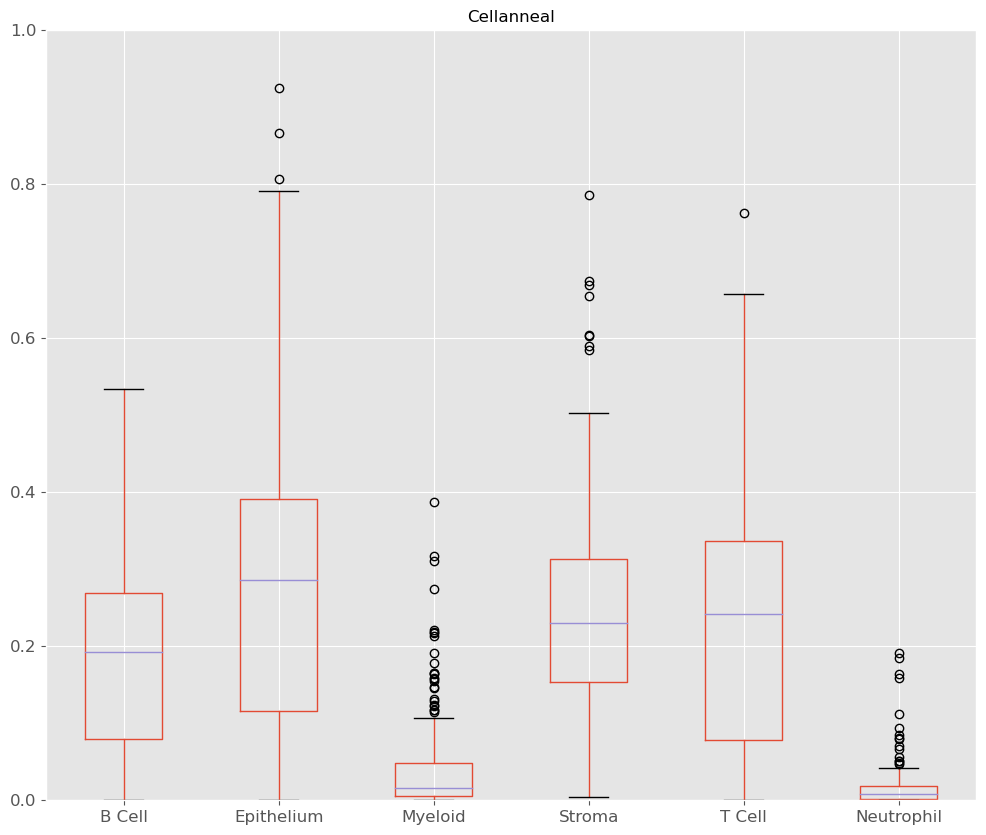

In [84]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

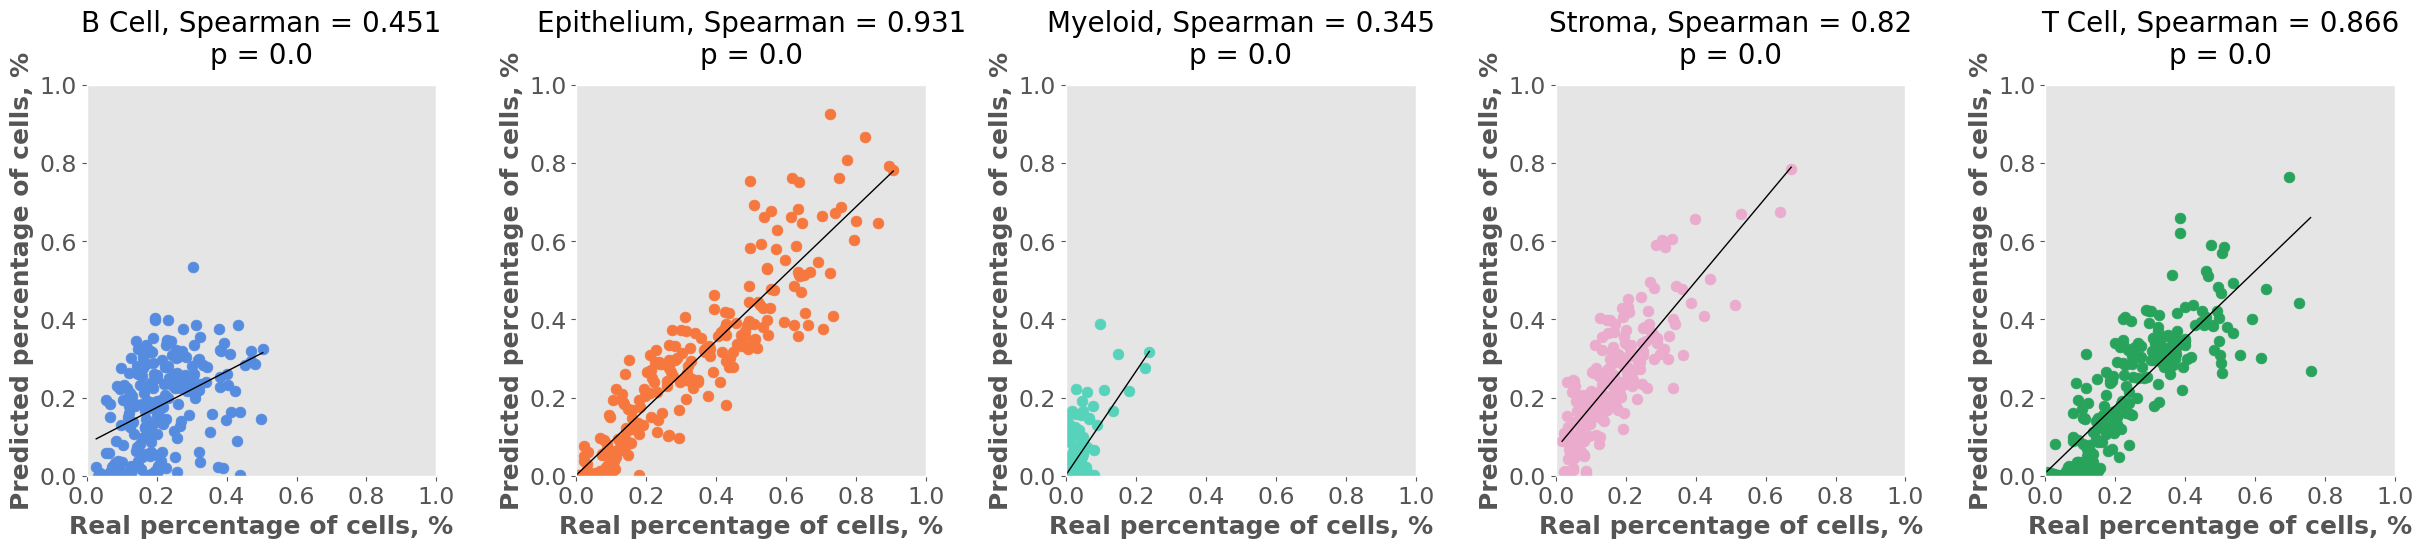

In [85]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()

In [86]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(45).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [87]:
ref

B Cell  Epithelium    Myeloid    Stroma     T Cell  Neutrophil
index                                                                        
ABCA8        4.078487    1.601451   2.721017  9.498291   3.094153    0.000000
AC007278.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.078481
AC007342.3   0.000000    0.000000   0.000000  0.000000   0.000000   18.596984
AC012645.1   0.000000    0.000000   0.000000  0.000000   0.000000   17.160102
AC020636.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.050198
...               ...         ...        ...       ...        ...         ...
UGT2B17      6.093878   10.359428   4.518254  3.251111   4.558168    0.000000
VNN3         0.000000    0.000000   0.000000  0.000000   0.000000   17.804401
VPREB3      11.574543    2.818467   4.884204  2.316491   4.995429    0.000000
VSIG2        5.084660   10.173351   3.255996  3.592262   4.025002    0.000000
ZNF331      11.121237    4.951071  10.011778  6.260785  11.157730    7.712262

[214 rows x 6 columns]

In [88]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_45.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_45.csv",index_col=0)
    pass

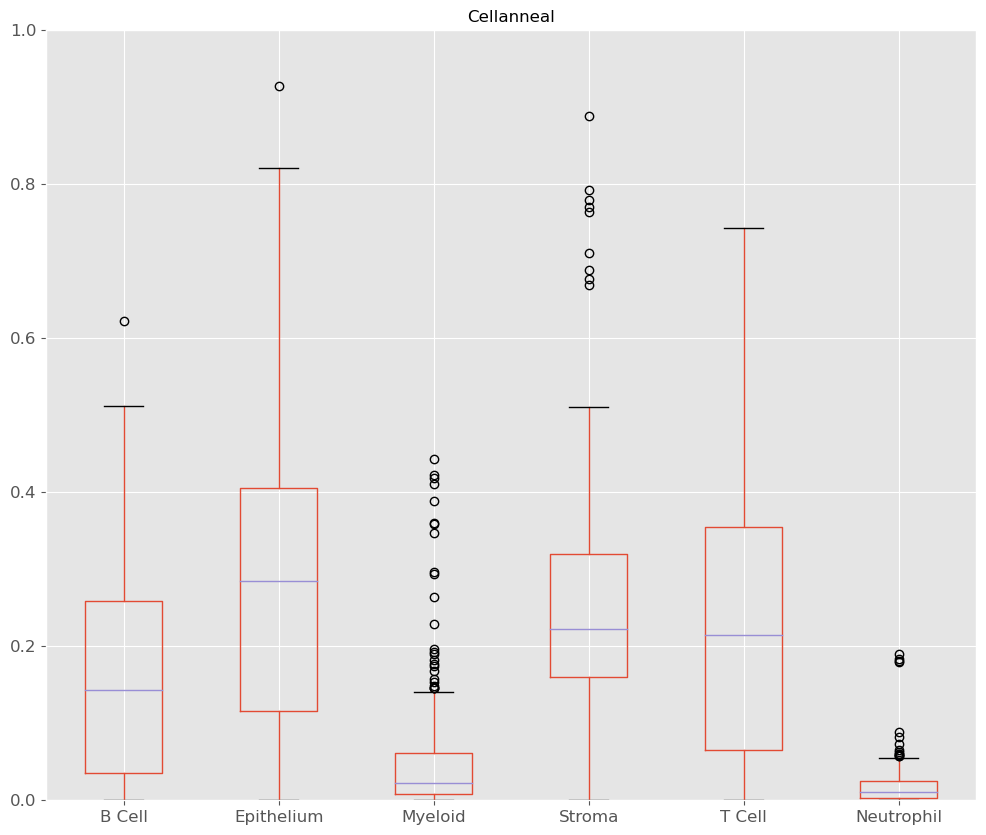

In [89]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

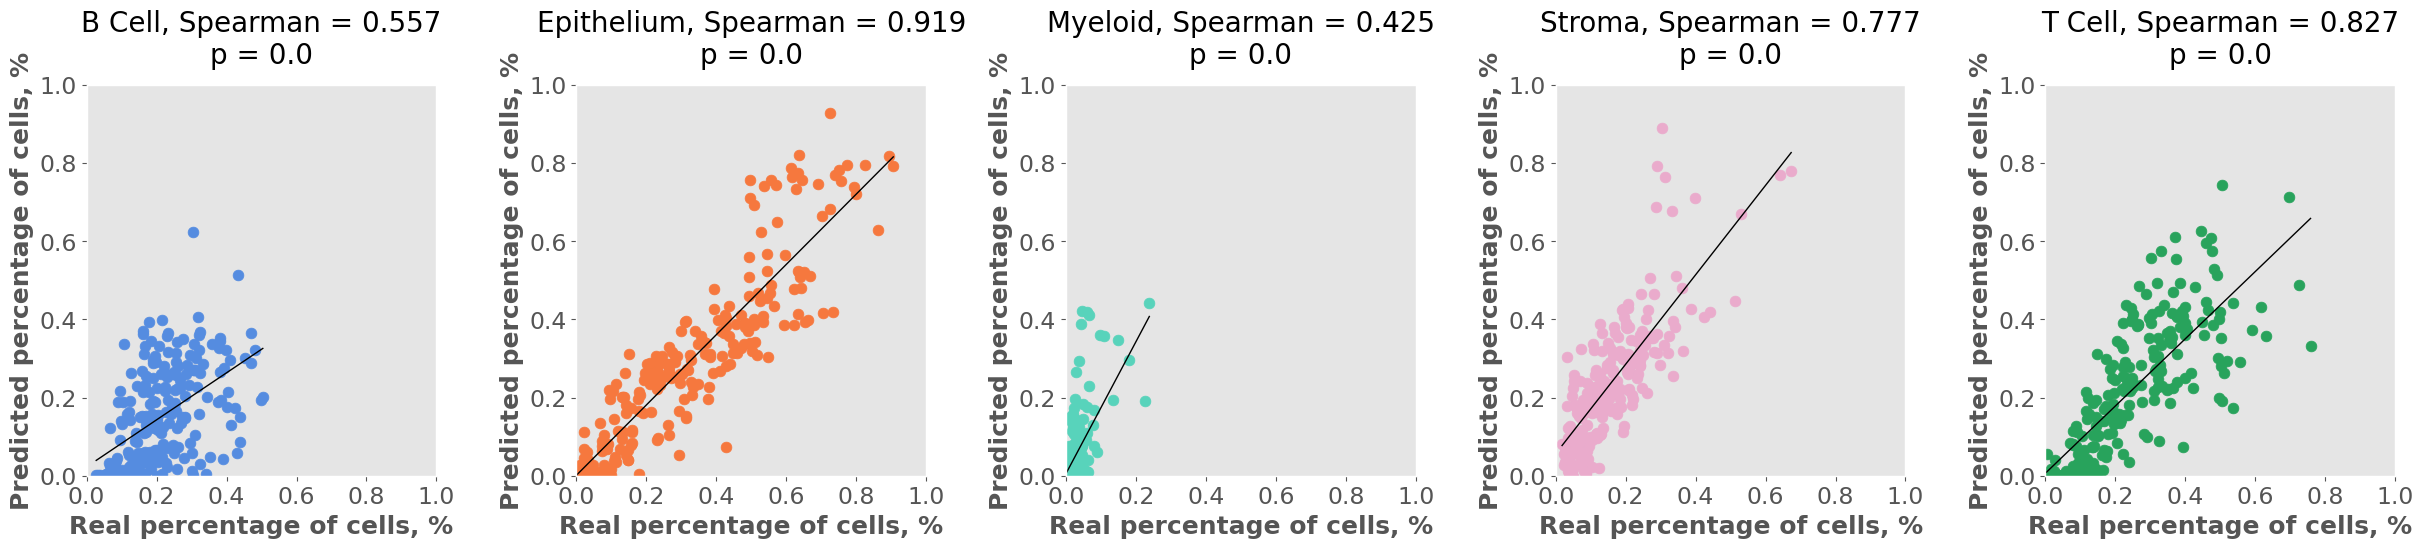

In [90]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()

In [91]:
# ref.to_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/best_ref_neutrophils.csv")

In [96]:
ref

B Cell  Epithelium    Myeloid    Stroma     T Cell  Neutrophil
index                                                                        
ABCA8        4.078487    1.601451   2.721017  9.498291   3.094153    0.000000
AC007278.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.078481
AC007342.3   0.000000    0.000000   0.000000  0.000000   0.000000   18.596984
AC012645.1   0.000000    0.000000   0.000000  0.000000   0.000000   17.160102
AC020636.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.050198
...               ...         ...        ...       ...        ...         ...
UGT2B17      6.093878   10.359428   4.518254  3.251111   4.558168    0.000000
VNN3         0.000000    0.000000   0.000000  0.000000   0.000000   17.804401
VPREB3      11.574543    2.818467   4.884204  2.316491   4.995429    0.000000
VSIG2        5.084660   10.173351   3.255996  3.592262   4.025002    0.000000
ZNF331      11.121237    4.951071  10.011778  6.260785  11.157730    7.712262

[214 rows x 6 columns]

In [162]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(45).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

# Get the indices of the top N nonzero entries of each compartment column
l =[]
for i in ref.columns:
    temp = ref
    temp = temp.replace(0,np.nan)
    temp = temp[i]
    temp=temp.dropna()
    temp = temp.sort_values(ascending=False)
    lx = temp.index.to_list()
    lx = lx[:45]
    l.append(lx)

# find all the unique genes by taking the intersection of all combinations of compartments
genes = []
for i in range(len(l)):
    for j in range(len(l)):
        if i == j:
            continue
        print(i,j)
        l1 = set(l[i]).intersection(set(l[j]))
        print(l1)
        genes.append(list(l1))

genes = [item for sublist in genes for item in sublist]
genes = list(set(genes))
print("Dropping {} Genes".format(len(genes)))

# # drop the intersecting genes from the reference
# for i in genes:
#     ref = ref.drop(i)

0 1
{'BTG1', 'IGHA1'}
0 2
{'IFITM2', 'CD69', 'DUSP2', 'BTG1', 'HLA-DRA', 'IGHA1', 'S100A4', 'PTPRC', 'CD52', 'RGCC', 'HERPUD1', 'HLA-DPB1', 'IGKC', 'SRGN', 'GPR183'}
0 3
{'IFITM2', 'IGHA2', 'BTG1', 'IGHA1', 'HLA-DRA', 'S100A4', 'RGCC', 'HERPUD1', 'IGKC', 'SRGN'}
0 4
{'IFITM2', 'IGHA2', 'BTG1', 'RGCC', 'ACAP1', 'SEPT6', 'SRGN', 'LTB', 'CD52', 'IGHM', 'CXCR4', 'CD69', 'S100A4', 'HERPUD1', 'IGLC3', 'DUSP2', 'GPR183', 'PTPRC', 'IGHA1', 'CREM', 'IGKC', 'ZNF331'}
0 5
set()
1 0
{'BTG1', 'IGHA1'}
1 2
{'BTG1', 'IGHA1'}
1 3
{'BTG1', 'IGHA1', 'IL32'}
1 4
{'BTG1', 'IGHA1', 'IL32'}
1 5
set()
2 0
{'IFITM2', 'CD69', 'DUSP2', 'BTG1', 'IGHA1', 'HLA-DRA', 'S100A4', 'PTPRC', 'CD52', 'RGCC', 'HERPUD1', 'IGKC', 'HLA-DPB1', 'SRGN', 'GPR183'}
2 1
{'BTG1', 'IGHA1'}
2 3
{'IFITM2', 'BTG1', 'IGHA1', 'HLA-DRA', 'S100A4', 'ANXA1', 'RGCC', 'HERPUD1', 'IGKC', 'SRGN'}
2 4
{'IFITM2', 'HCST', 'CD69', 'DUSP2', 'BTG1', 'IGHA1', 'S100A4', 'ANXA1', 'CD52', 'RGCC', 'HERPUD1', 'CCL4', 'TNFAIP3', 'IGKC', 'SRGN', 'GPR183', 'PT

In [141]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_unique.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_unique.csv",index_col=0)
    pass

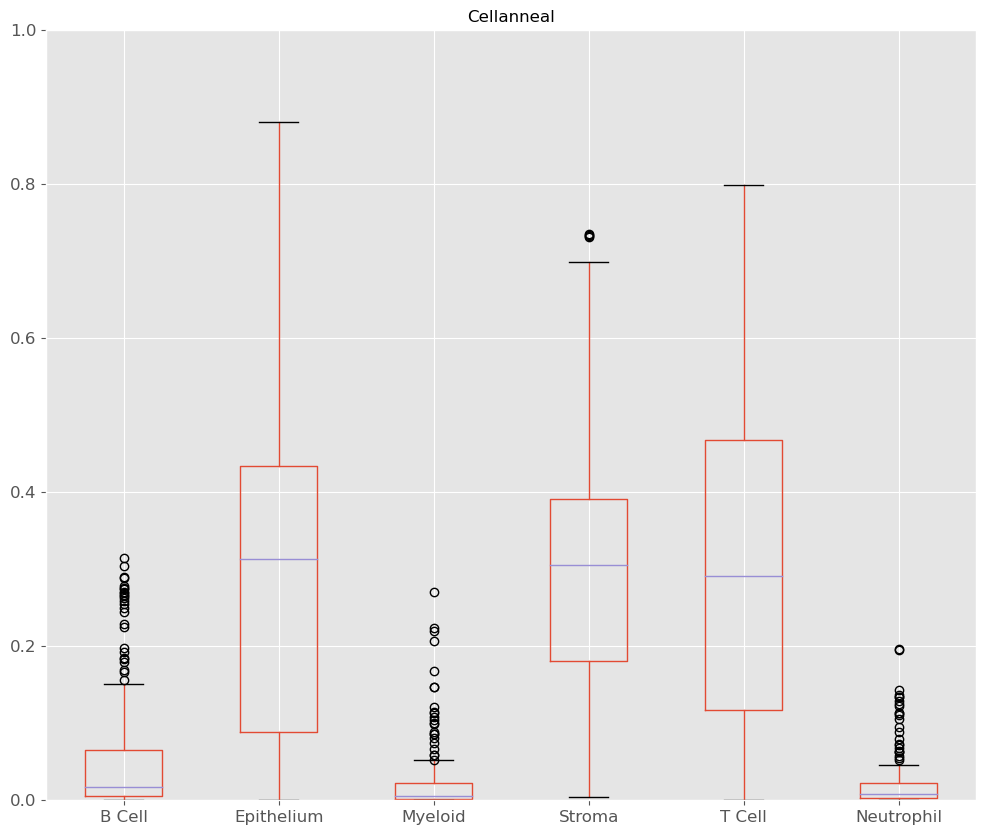

In [142]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

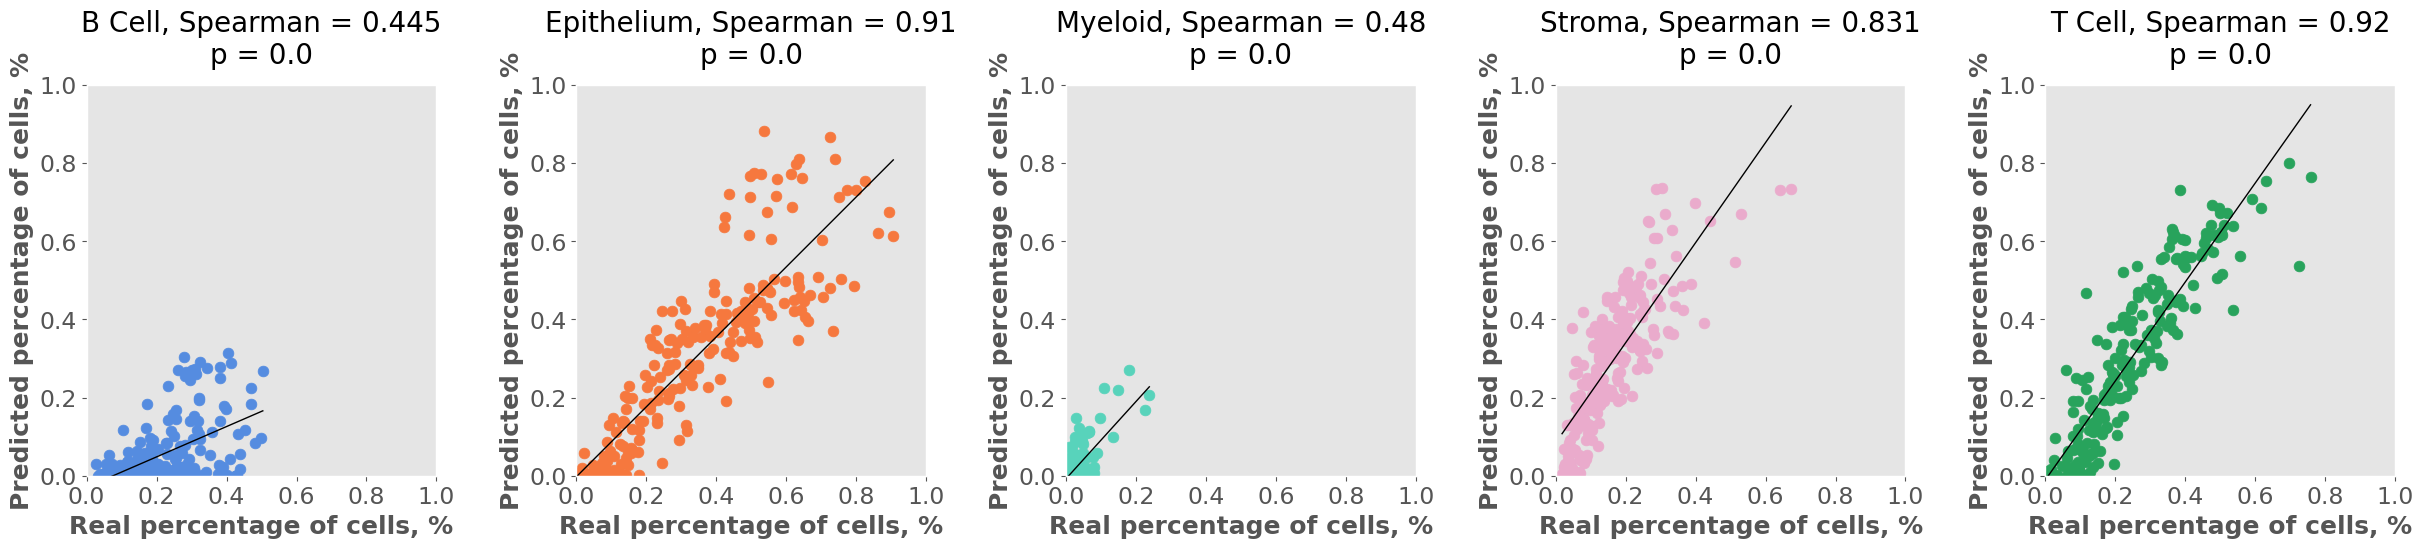

In [143]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()

## unique 2

In [145]:
if not train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_unique2.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_unique2.csv",index_col=0)
    pass

58 highly variable genes identified in cell type
        reference.
	53 of these are within thresholds for sample CID003352-2
	49 of these are within thresholds for sample CID003353-1
	50 of these are within thresholds for sample CID003354-1
	52 of these are within thresholds for sample CID003355-1
	53 of these are within thresholds for sample CID003356-1
	53 of these are within thresholds for sample CID003357-1
	52 of these are within thresholds for sample CID003358-1
	51 of these are within thresholds for sample CID003359-1
	53 of these are within thresholds for sample CID003360-1
	53 of these are within thresholds for sample CID003361-1
	50 of these are within thresholds for sample CID003362-1
	53 of these are within thresholds for sample CID003363-1
	52 of these are within thresholds for sample CID003364-1
	53 of these are within thresholds for sample CID003365-1
	51 of these are within thresholds for sample CID003366-1
	52 of these are within thresholds for sample CID003367-2
	53 

In [148]:
genes

['IFITM2',
 'IGHA2',
 'BTG1',
 'IGHA1',
 'S100A4',
 'ANXA1',
 'RGCC',
 'HERPUD1',
 'IGKC',
 'SRGN',
 'IL32']

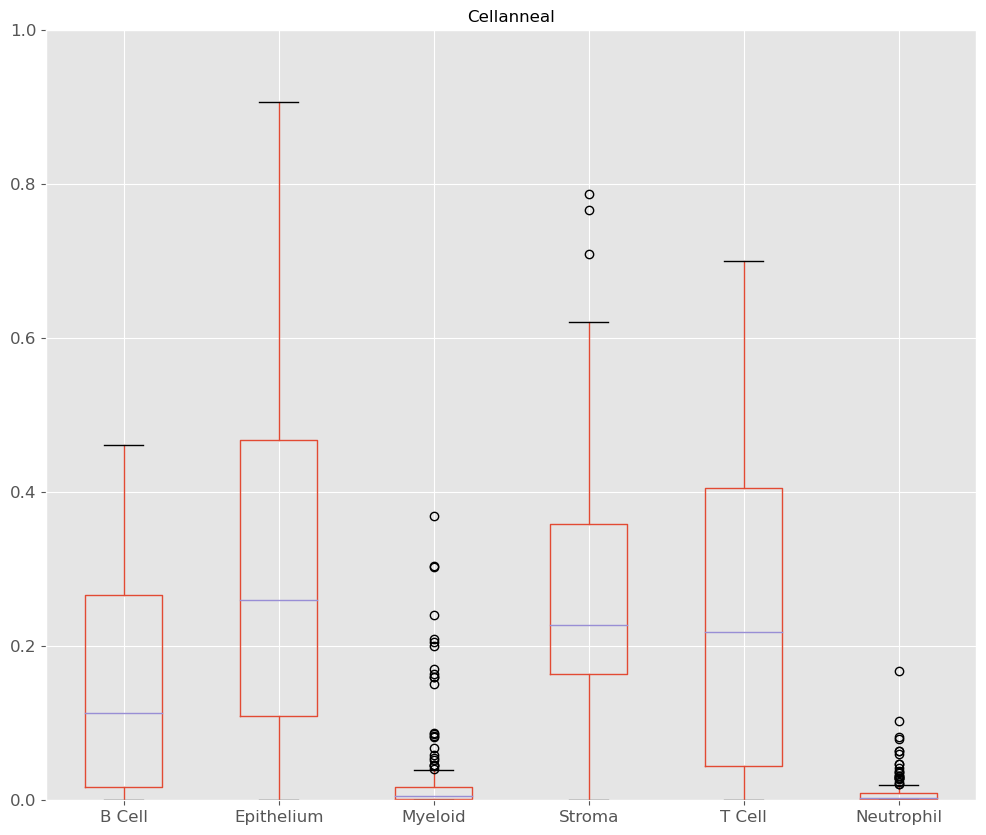

In [146]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

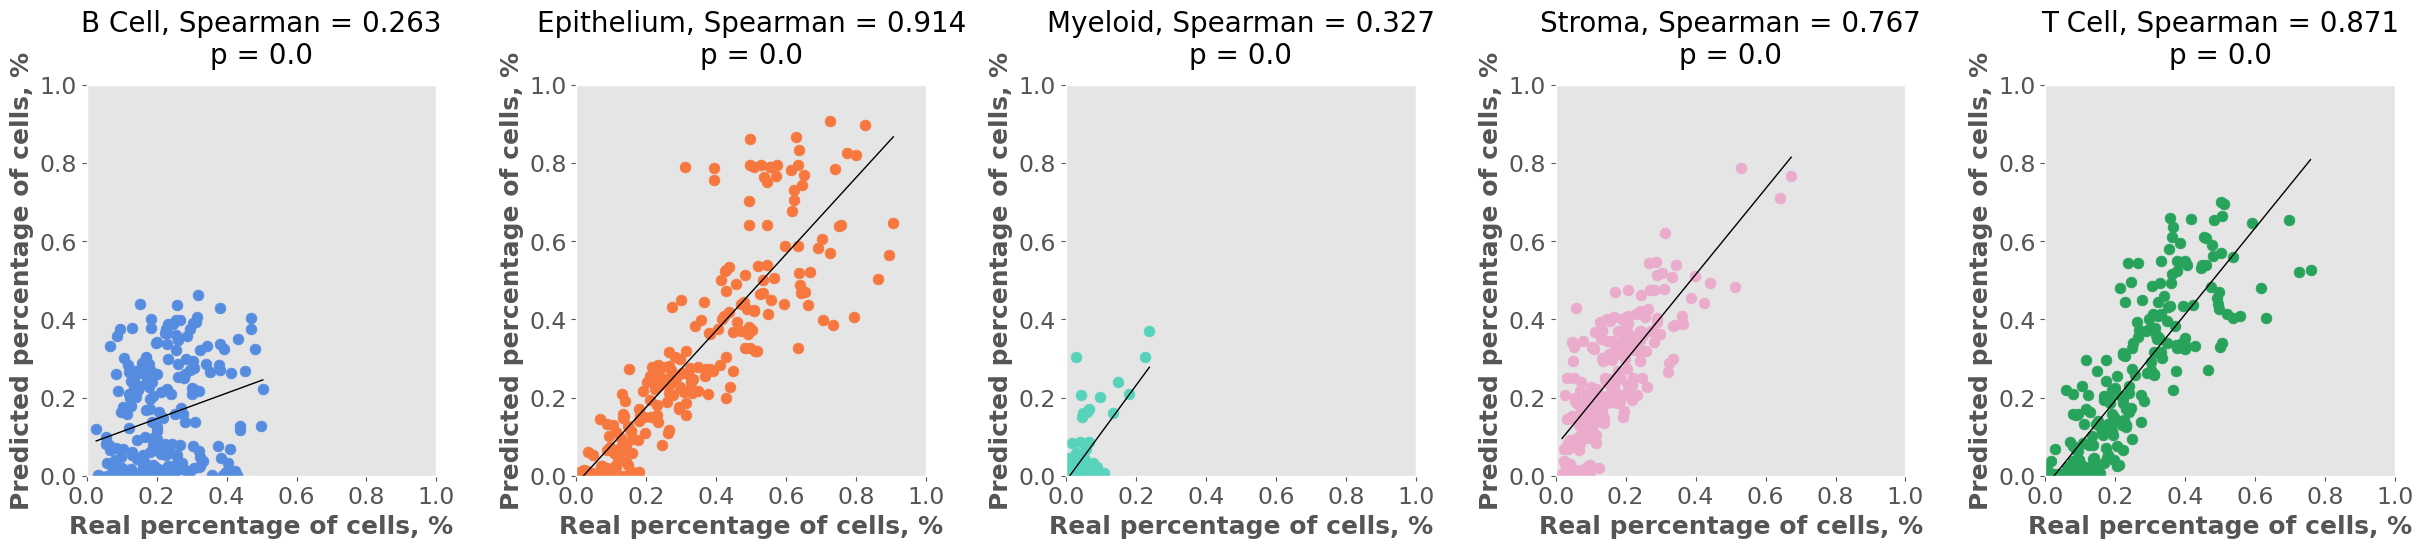

In [147]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()

### Unique 3

In [150]:
genes

['IFITM2',
 'IGHA2',
 'HCST',
 'BTG1',
 'RGCC',
 'SRGN',
 'CD52',
 'CD69',
 'S100A4',
 'HERPUD1',
 'DUSP2',
 'PTPRC',
 'GPR183',
 'HLA-DRA',
 'IGHA1',
 'ANXA1',
 'CCL4',
 'IGKC',
 'TNFAIP3',
 'IL32']

In [151]:
if not train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results9/cellanneal_neutrophil_unique3.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results9/cellanneal_neutrophil_unique3.csv",index_col=0)
    pass

53 highly variable genes identified in cell type
        reference.
	51 of these are within thresholds for sample CID003352-2
	49 of these are within thresholds for sample CID003353-1
	49 of these are within thresholds for sample CID003354-1
	50 of these are within thresholds for sample CID003355-1
	51 of these are within thresholds for sample CID003356-1
	51 of these are within thresholds for sample CID003357-1
	50 of these are within thresholds for sample CID003358-1
	49 of these are within thresholds for sample CID003359-1
	51 of these are within thresholds for sample CID003360-1
	51 of these are within thresholds for sample CID003361-1
	50 of these are within thresholds for sample CID003362-1
	51 of these are within thresholds for sample CID003363-1
	51 of these are within thresholds for sample CID003364-1
	51 of these are within thresholds for sample CID003365-1
	50 of these are within thresholds for sample CID003366-1
	51 of these are within thresholds for sample CID003367-2
	51 

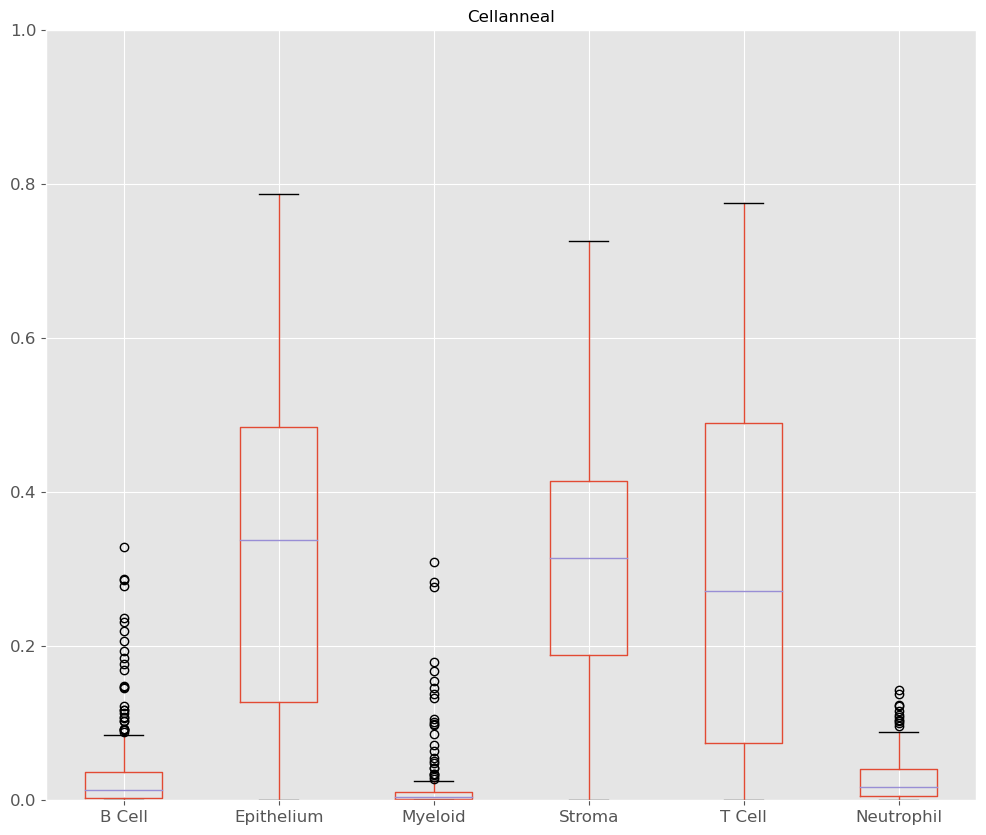

In [152]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

In [160]:
ref

B Cell  Epithelium    Myeloid    Stroma     T Cell  Neutrophil
index                                                                        
ABCA8        4.078487    1.601451   2.721017  9.498291   3.094153    0.000000
AC007278.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.078481
AC007342.3   0.000000    0.000000   0.000000  0.000000   0.000000   18.596984
AC012645.1   0.000000    0.000000   0.000000  0.000000   0.000000   17.160102
AC020636.1   0.000000    0.000000   0.000000  0.000000   0.000000   18.050198
...               ...         ...        ...       ...        ...         ...
UGT2B17      6.093878   10.359428   4.518254  3.251111   4.558168    0.000000
VNN3         0.000000    0.000000   0.000000  0.000000   0.000000   17.804401
VPREB3      11.574543    2.818467   4.884204  2.316491   4.995429    0.000000
VSIG2        5.084660   10.173351   3.255996  3.592262   4.025002    0.000000
ZNF331      11.121237    4.951071  10.011778  6.260785  11.157730    7.712262

[214 rows x 6 columns]

In [161]:
for i in genes: 
    print(i)
    temp = ref.drop(i)
    cellanneal_atap = deconvolution_object.deconvolution(temp, atap_bulk)
    cellanneal_atap.to_csv("../data/genes/"+i+".csv")
    

IFITM2
71 highly variable genes identified in cell type
        reference.
	59 of these are within thresholds for sample CID003352-2
	53 of these are within thresholds for sample CID003353-1
	56 of these are within thresholds for sample CID003354-1
	58 of these are within thresholds for sample CID003355-1
	59 of these are within thresholds for sample CID003356-1
	59 of these are within thresholds for sample CID003357-1
	55 of these are within thresholds for sample CID003358-1
	57 of these are within thresholds for sample CID003359-1
	57 of these are within thresholds for sample CID003360-1
	59 of these are within thresholds for sample CID003361-1
	55 of these are within thresholds for sample CID003362-1
	59 of these are within thresholds for sample CID003363-1
	58 of these are within thresholds for sample CID003364-1
	58 of these are within thresholds for sample CID003365-1
	57 of these are within thresholds for sample CID003366-1
	58 of these are within thresholds for sample CID003367

In [172]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(45).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [173]:
genes = ["TNFAIP3", "CD69", "HERPUD1", "CD52", "IFITM2", "IGHA2", "IGLC3", "LTB", "ZNF331", "ACAP1", "ANXA1", "CREM", "HCST", "HLA-DPB1", "PTPRC", "S100A4", "IGHM", "IGHA1", "GPR183", "HLA-DRA", "SRGN"]

In [174]:
for i in genes:
     ref = ref.drop(i)

In [12]:
cellanneal_atap = pd.read_csv("../data/genes/best.csv",index_col=0)

In [13]:
cellanneal_atap

B Cell  Epithelium   Myeloid    Stroma    T Cell  Neutrophil  \
CID003352-2  0.102162    0.066961  0.018259  0.519357  0.274906    0.018354   
CID003353-1  0.010577    0.645612  0.004577  0.008977  0.324156    0.006101   
CID003354-1  0.002286    0.563105  0.000587  0.304508  0.128345    0.001169   
CID003355-1  0.024640    0.308128  0.007591  0.022797  0.624348    0.012496   
CID003356-1  0.002345    0.192764  0.003251  0.317488  0.473200    0.010952   
...               ...         ...       ...       ...       ...         ...   
CID006580-1  0.007004    0.001741  0.244369  0.007288  0.713596    0.026001   
CID006581-1  0.157031    0.000199  0.125874  0.170447  0.545016    0.001432   
CID006582-1  0.106471    0.057506  0.012968  0.348461  0.466187    0.008407   
CID006583-1  0.028505    0.005901  0.010988  0.300231  0.646689    0.007685   
CID006584-1  0.009852    0.164697  0.002045  0.310397  0.467427    0.045582   

             rho_Spearman  rho_Pearson  
CID003352-2      0.923163     0.866142  
CID003353-1      0.941721     0.796437  
CID003354-1      0.916975     0.845379  
CID003355-1      0.875706     0.689602  
CID003356-1      0.913878     0.846883  
...                   ...          ...  
CID006580-1      0.891829     0.746829  
CID006581-1      0.913700     0.829824  
CID006582-1      0.910204     0.785466  
CID006583-1      0.887449     0.825151  
CID006584-1      0.860816     0.790404  

[223 rows x 8 columns]

In [175]:
cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
cellanneal_atap.to_csv("../data/genes/best.csv")

52 highly variable genes identified in cell type
        reference.
	49 of these are within thresholds for sample CID003352-2
	47 of these are within thresholds for sample CID003353-1
	47 of these are within thresholds for sample CID003354-1
	48 of these are within thresholds for sample CID003355-1
	49 of these are within thresholds for sample CID003356-1
	49 of these are within thresholds for sample CID003357-1
	48 of these are within thresholds for sample CID003358-1
	47 of these are within thresholds for sample CID003359-1
	49 of these are within thresholds for sample CID003360-1
	49 of these are within thresholds for sample CID003361-1
	48 of these are within thresholds for sample CID003362-1
	49 of these are within thresholds for sample CID003363-1
	49 of these are within thresholds for sample CID003364-1
	49 of these are within thresholds for sample CID003365-1
	48 of these are within thresholds for sample CID003366-1
	49 of these are within thresholds for sample CID003367-2
	49 

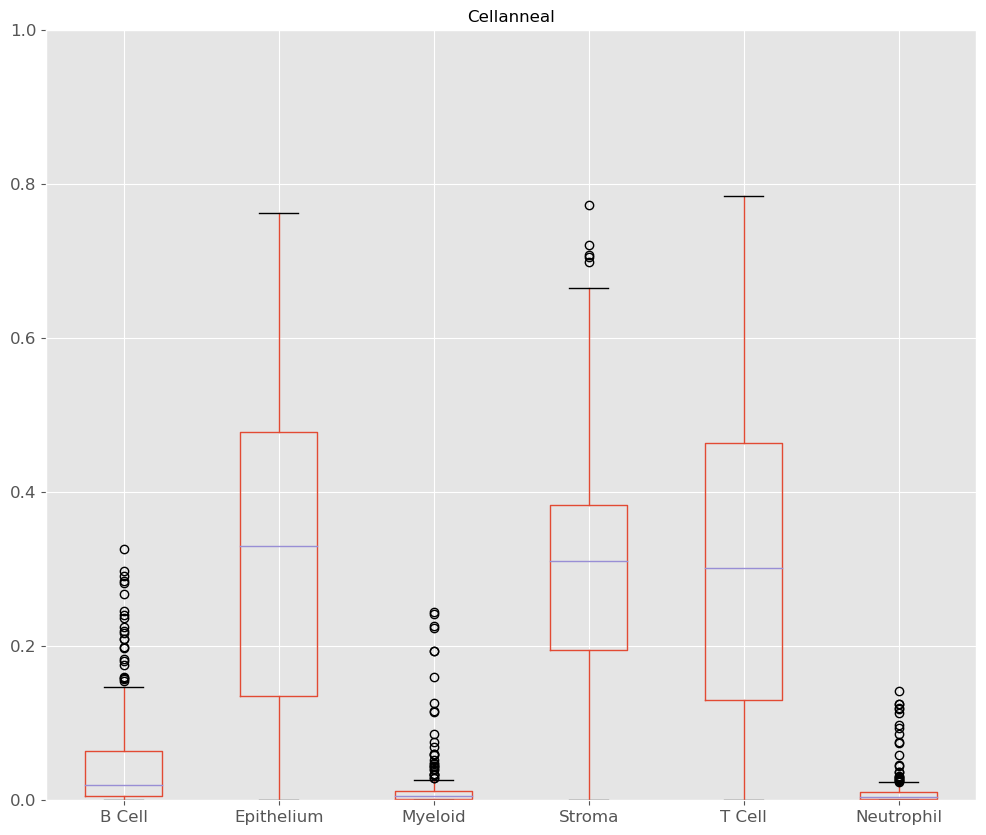

In [14]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

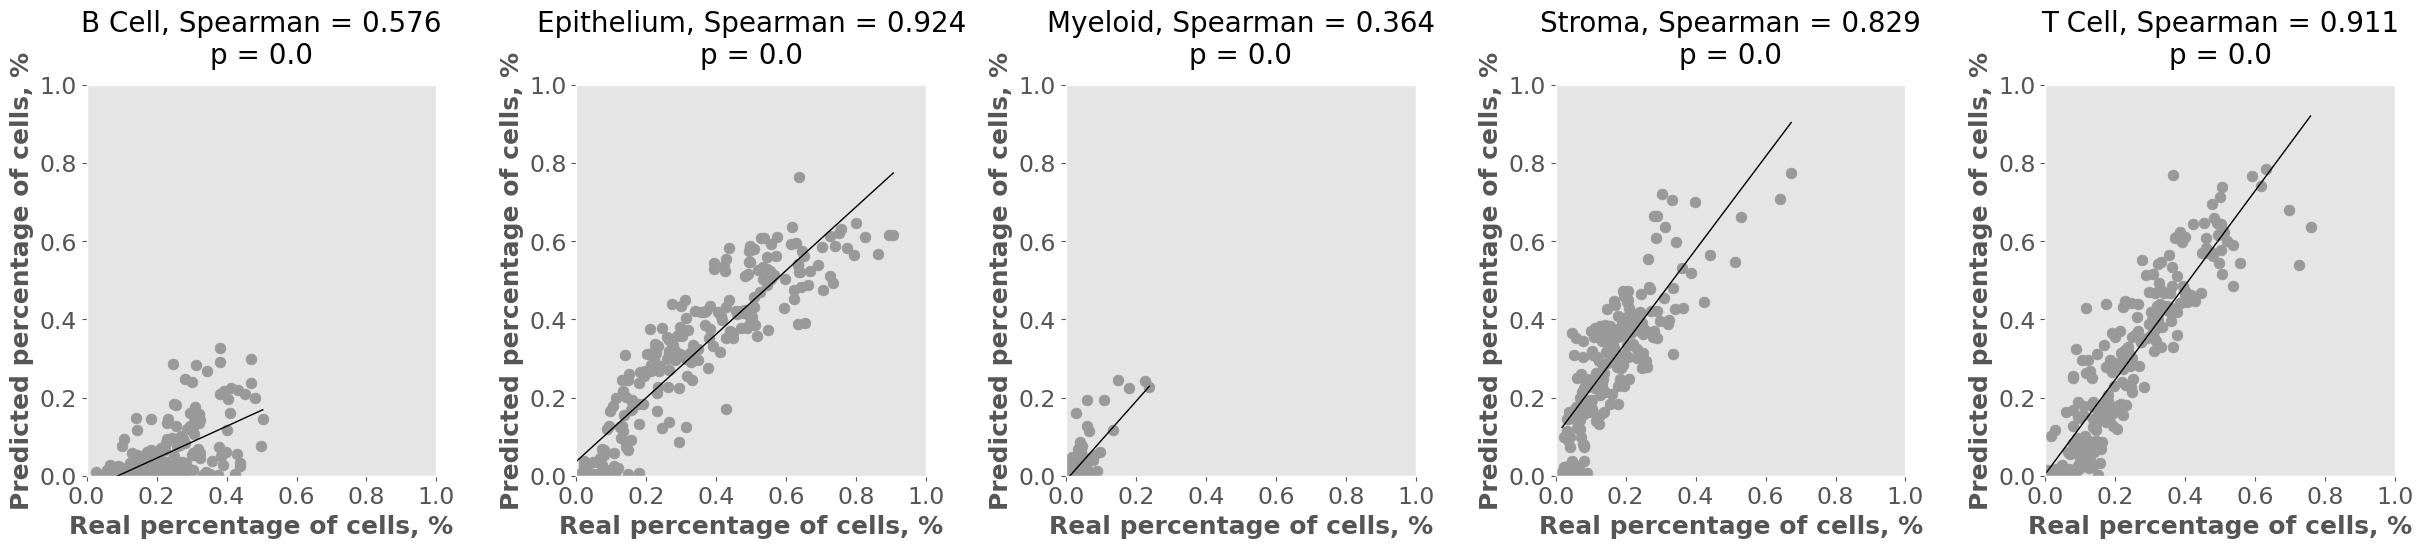

In [15]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)
plt.show()